# GALAH DR4 Stellar Label Optimisation


In [1]:
# Preamble
try:
    %matplotlib inline
    %config InlineBackend.figure_format='retina'
except:
    pass

import numpy as np
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
from astropy.io import fits
import astropy.constants as c
import logging
import time
import copy
from pathlib import Path
import pickle
import astropy.units as u
from astropy.table import Table
import scipy.interpolate
from scipy import signal
from scipy.spatial import cKDTree
import scipy.optimize as op
from scipy.ndimage.filters import convolve
from scipy.io import readsav
import thecannon as tc
import emcee
import corner

# Corrections to non-spectroscopic data
from astroquery.gaia import Gaia
from zero_point import zpt
zpt.load_tables()

Created TAP+ (v1.2.1) - Connection:
	Host: gea.esac.esa.int
	Use HTTPS: True
	Port: 443
	SSL Port: 443
Created TAP+ (v1.2.1) - Connection:
	Host: geadata.esac.esa.int
	Use HTTPS: True
	Port: 443
	SSL Port: 443


In [2]:
# Create dictionary for descriptions
description = dict()
description['sobject_id'] = 'GALAH identifier'
description['tmass_id'] = '2MASS identifier'
description['gaia_edr3_source_id'] = 'Gaia DR2 source_id'
description['teff'] = 'Spectroscopic effective temperature'
description['logg'] = 'Surface gravity'
description['fe_h'] = 'Fe abundance [Fe/H] (1D-NLTE)'
description['vmic'] = 'Microturbulence velocity'
description['vsini'] = 'Rotational broadening velocity'
for element in ['Li','C','N','O','Na','Mg','Al','Si','K','Ca','Sc','Ti','V','Cr','Mn','Co','Ni','Cu','Zn','Rb','Sr','Y','Zr','Mo','Ru','Ba','La','Ce','Nd','Sm','Eu']:
    if element in ['Li','C','N','O','Na','Mg','Al','Si','K','Ca','Mn','Ba']:
        lte_nlte = 'NLTE'
    else:
        lte_nlte = 'LTE'        
    description[element.lower()+'_fe'] = element+' abundance ['+element+'/Fe] (1D-'+lte_nlte+')'
description['vrad'] = 'Radial velocity fitted from spectra'
for ccd in [1,2,3,4]:
    description['cdelt'+str(ccd)] = 'Linear wavelength increase per pixel for CCD'+str(ccd)
    description['crval'+str(ccd)] = 'Wavelength of first pixel for CCD'+str(ccd)
description['distance'] = 'Distance from Sun to star'
description['a_v'] = 'Extinction in V filter'

In [3]:
# Create dictionary for units
units = dict()
for each in description.keys():
    units[each] = ''
    if each in ['sobject_id','tmass_id','gaia_edr3_source_id']:
        pass
    elif each in ['teff']:
        units[each] = 'K'
    elif each in ['logg']:
        units[each] = 'log(cm.s**-2)'
    elif each in ['fe_h']:
        units[each] = 'dex'
    elif each in ['vmic','vsini','vrad']:
        units[each] = 'km s-1'
    elif each[-3:] == '_fe':
        units[each] = 'dex'
    elif each in ['distance']:
        units[each] = 'pc'
    elif each in ['a_v']:
        units[each] = 'mag'
    elif each[:5] in ['cdelt']:
        units[each] = 'Angstroem/pix'
    elif each[:5] in ['crval']:
        units[each] = 'Angstroem'
    else:
        print("'"+each+"',")

In [4]:
print("To Do:")
print("Better isochrone set and interpolation routine from Sanjib")
print("Implement some mechanism that checks the ph_qual flag for chi2 and only uses A?")

To Do:
Better isochrone set and interpolation routine from Sanjib
Implement some mechanism that checks the ph_qual flag for chi2 and only uses A?


In [5]:
#sobject_id = 150427000801285 # GRID POINT: 1511 red giant with numax
#sobject_id = 150606003401143
#sobject_id = 170509004701075
sobject_id = 170509004701096 # GRID POINT: 1931 solar twin
#sobject_id = ... Arcturus # GRID POINT: 1259

use_photoastrometry = True
use_asteroseismology = True

debug = False

working_directory = '/Users/svenbuder/GALAH_DR4/'
spectra_directory = working_directory+'observations/'
cannon_model_directory = working_directory+'spectrum_interpolation/TheCannon/models/'

# Get observation and initial parameters

In [6]:
def get_reduction_products(sobject_id, neglect_ir_beginning=True):

    """
    This function collects the spectrum and other reduction products.
    
    INPUT:
    sobject_id: identifier for spectra
    neglect_ir_beginning: Cut away CCD4 information below 7700Å?

    OUTPUT:
    spectrum - dictionary with the following keywords:
    - sobject_id: identifier for GALAH
    - tmass_id: identifier for 2MASS
    - gaia_edr3_source_id: identifier for GaiaEDR3
    - init_teff: Teff value suggested by reduction
    - init_logg: logg value suggested by reduction
    - init_fe_h: [Fe/H] value suggested by reduction
    - init_x_fe: [X/Fe] for alpha-process elements C, O, Mg, Si, Ca, Ti
    - init_vmic: vmic value suggested by reduction
    - init_vsini: vsini value suggested by reduction
    - init_vrad: vrad value suggested by reduction

    """
    spectrum = dict()

    spectrum['sobject_id'] = sobject_id

    fits_file = fits.open(spectra_directory+str(sobject_id)[:6]+'/spectra/com/'+str(sobject_id)+'1.fits')

    spectrum['galah_id'] = fits_file[0].header['GALAH_ID']
    spectrum['tmass_id'] = fits_file[0].header['2MASS_ID']
    spectrum['gaia_edr3_source_id'] = fits_file[0].header['GAIA_ID']

    if fits_file[0].header['PAR_OK']==1:
        
        # TEFF
        spectrum['init_teff'] = fits_file[0].header['TEFF_R']
        if spectrum['init_teff'] < 3000:
            raise ValueError('TEFF < 3000')
        if spectrum['init_teff'] > 8000:
            raise ValueError('TEFF > 8000')
        
        # LOGG
        spectrum['init_logg'] = fits_file[0].header['LOGG_R']
        if spectrum['init_logg'] < -0.5:
            raise ValueError('LOGG < -0.5')
        if spectrum['init_logg'] > 5.5:
            raise ValueError('LOGG > 5.5')
            
        # FE_H
        spectrum['init_fe_h'] = fits_file[0].header['FE_H_R']
        if spectrum['init_fe_h'] < -4.0:
            raise ValueError('LOGG < -4.0')
        if spectrum['init_fe_h'] > 1.0:
            raise ValueError('LOGG > 1.0')
        
        for element in ['Li','C','N','O','Na','Mg','Al','Si','K','Ca','Sc','Ti','V','Cr','Mn','Co','Ni','Cu','Zn','Rb','Sr','Y','Zr','Mo','Ru','Ba','La','Ce','Nd','Sm','Eu']:
            spectrum['init_'+element.lower()+'_fe'] = 0.0

        # ALPHA_FE -> C, O, Si, Mg, Ca, Ti
        for each_alpha in ['c','o','mg','si','ca','ti']:
            spectrum['init_'+each_alpha+'_fe'] = fits_file[0].header['A_FE_R']
            if spectrum['init_'+each_alpha+'_fe'] < -1.0:
                raise ValueError('['+each_alpha+'/Fe] < -1.0')
            if spectrum['init_'+each_alpha+'_fe'] > 1.0:
                raise ValueError('['+each_alpha+'/Fe] > 1.0')
            
        # VMIC
        spectrum['init_vmic'] = fits_file[0].header['VMIC_R']
        
        # VBROAD
        spectrum['init_vsini'] = fits_file[0].header['VBROAD_R']

    else:
        raise ValueError('Reduction parameters not trustworthy!')

    if fits_file[0].header['RVCOM_OK']==1:
        spectrum['init_vrad'] = fits_file[0].header['RVCOM']
    else:
        raise ValueError('RV pipeline did not converge!')

    if fits_file[0].header['WAV_OK']==0:
        raise ValueError('Wavelength solution not ok!')

    if fits_file[0].header['CROSS_OK']==0:
        raise ValueError('Cross-talk not calculated reliably!')

    for ccd in [1,2,3,4]:

        if ccd != 1:
            fits_file = fits.open(spectra_directory+str(sobject_id)[:6]+'/spectra/com/'+str(sobject_id)+str(ccd)+'.fits')

        spectrum['crval_ccd'+str(ccd)] = fits_file[0].header['CRVAL1']
        spectrum['cdelt_ccd'+str(ccd)] = fits_file[0].header['CDELT1']

        spectrum['counts_ccd'+str(ccd)]   = fits_file[0].data
        spectrum['counts_unc_ccd'+str(ccd)] = fits_file[0].data * fits_file[2].data

        spectrum['sky_ccd'+str(ccd)]   = fits_file[3].data
        spectrum['telluric_ccd'+str(ccd)]   = fits_file[4].data

        spectrum['lsf_b_ccd'+str(ccd)] = fits_file[0].header['B']
        spectrum['lsf_ccd'+str(ccd)]   = fits_file[7].data
        
        fits_file.close()

        if (ccd == 4) & neglect_ir_beginning:
            wave_ccd4 = spectrum['crval_ccd4'] + spectrum['cdelt_ccd4'] * np.arange(len(spectrum['counts_ccd4']))
            bad_ir = wave_ccd4 > 7698
            spectrum['crval_ccd4'] = wave_ccd4[bad_ir][0]
            spectrum['counts_ccd4'] = spectrum['counts_ccd4'][bad_ir]
            spectrum['counts_unc_ccd4'] = spectrum['counts_unc_ccd4'][bad_ir]
            spectrum['lsf_ccd4'] = spectrum['lsf_ccd4'][bad_ir]

    return(spectrum)

spectrum = get_reduction_products(sobject_id)

In [7]:
def exchange_with_reliable_galah_dr3_values(spectrum):

    galah_dr3 = Table.read('../auxiliary_information/GALAH_DR3_main_allspec_v2_lite.fits')
    galah_dr3_match = np.where(galah_dr3['sobject_id'] == spectrum['sobject_id'])[0]
    if len(galah_dr3_match) > 0:
        print('Found match in GALAH+ DR3')
        galah_dr3_entry = galah_dr3[galah_dr3_match[0]]

        if galah_dr3_entry['flag_sp'] == 0:
            print('Replacing initial value for Teff, logg, vmic, vsini with GALAH+ DR3 ones.')
            for label in ['teff','logg','vmic','vsini']:
                label2 = label
                if label=='vsini':
                    label2 = 'vbroad'
                print(label+' IRAF 6.0: ',"{:.2f}".format(spectrum['init_'+label]), 'GALAH+ DR3: ',"{:.2f}".format(galah_dr3_entry[label2]))
                spectrum['init_'+label] = galah_dr3_entry[label2]

            if galah_dr3_entry['flag_fe_h'] == 0:
                print('Replacing initial value for [Fe/H] with GALAH+ DR3 ones.')
                print('[Fe/H] IRAF 6.0: ',"{:.2f}".format(spectrum['init_fe_h']), 'GALAH+ DR3: ',"{:.2f}".format(galah_dr3_entry['fe_h']))
                spectrum['init_fe_h'] = galah_dr3_entry['fe_h']

            for element in ['Li','C','O','Na','Mg','Al','Si','K','Ca','Sc','Ti','V','Cr','Mn','Co','Ni','Cu','Zn','Rb','Sr','Y','Zr','Mo','Ru','Ba','La','Ce','Nd','Sm','Eu']:
                if galah_dr3_entry['flag_'+element+'_fe'] == 0:
                    print('['+element+'/Fe] initial value from GALAH+ DR3: '+"{:.2f}".format(galah_dr3_entry[element+'_fe']))

                    spectrum['init_'+element.lower()+'_fe'] = galah_dr3_entry[element+'_fe']

exchange_with_reliable_galah_dr3_values(spectrum)

Found match in GALAH+ DR3
Replacing initial value for Teff, logg, vmic, vsini with GALAH+ DR3 ones.
teff IRAF 6.0:  5628.43 GALAH+ DR3:  5727.23
logg IRAF 6.0:  4.33 GALAH+ DR3:  4.45
vmic IRAF 6.0:  1.11 GALAH+ DR3:  1.14
vsini IRAF 6.0:  4.89 GALAH+ DR3:  5.15
Replacing initial value for [Fe/H] with GALAH+ DR3 ones.
[Fe/H] IRAF 6.0:  -0.03 GALAH+ DR3:  -0.01
[Li/Fe] initial value from GALAH+ DR3: 0.55
[C/Fe] initial value from GALAH+ DR3: -0.01
[O/Fe] initial value from GALAH+ DR3: -0.06
[Na/Fe] initial value from GALAH+ DR3: -0.02
[Mg/Fe] initial value from GALAH+ DR3: -0.00
[Al/Fe] initial value from GALAH+ DR3: 0.03
[Si/Fe] initial value from GALAH+ DR3: 0.01
[K/Fe] initial value from GALAH+ DR3: -0.03
[Ca/Fe] initial value from GALAH+ DR3: -0.01
[Sc/Fe] initial value from GALAH+ DR3: 0.01
[Ti/Fe] initial value from GALAH+ DR3: 0.02
[V/Fe] initial value from GALAH+ DR3: -0.06
[Cr/Fe] initial value from GALAH+ DR3: -0.03
[Mn/Fe] initial value from GALAH+ DR3: 0.01
[Ni/Fe] initial v

In [8]:
# Correction of Gaia Gband magnitude and flux.
# The code is listed in the appendix of Gaia Collaboration et al. (2021), and 
# implements the formulae presented in Riello et al. (2021): https://ui.adsabs.harvard.edu/abs/2021A%26A...649A...3R/abstract
# Code retrieved from https://github.com/agabrown/gaiaedr3-6p-gband-correction/ 

def correct_gband(bp_rp, astrometric_params_solved, phot_g_mean_mag, phot_g_mean_flux):
    """
    Correct the G-band fluxes and magnitudes for the input list of Gaia EDR3 data.
    
    Parameters
    ----------
    
    bp_rp: float, numpy.ndarray
        The (BP-RP) colour listed in the Gaia EDR3 archive.
    astrometric_params_solved: int, numpy.ndarray
        The astrometric solution type listed in the Gaia EDR3 archive.
    phot_g_mean_mag: float, numpy.ndarray
        The G-band magnitude as listed in the Gaia EDR3 archive.
    phot_g_mean_flux: float, numpy.ndarray
        The G-band flux as listed in the Gaia EDR3 archive.
        
    Returns
    -------
    
    The corrected G-band magnitudes and fluxes. The corrections are only applied to
    sources with a 2-paramater or 6-parameter astrometric solution fainter than G=13, 
    for which a (BP-RP) colour is available.
    
    Example
    -------
    
    gmag_corr, gflux_corr = correct_gband(bp_rp, astrometric_params_solved, phot_g_mean_mag, phot_g_mean_flux)
    """

    if np.isscalar(bp_rp) or np.isscalar(astrometric_params_solved) or np.isscalar(phot_g_mean_mag) \
                    or np.isscalar(phot_g_mean_flux):
        bp_rp = np.float64(bp_rp)
        astrometric_params_solved = np.int64(astrometric_params_solved)
        phot_g_mean_mag = np.float64(phot_g_mean_mag)
        phot_g_mean_flux = np.float64(phot_g_mean_flux)
    
    if not (bp_rp.shape == astrometric_params_solved.shape == phot_g_mean_mag.shape == phot_g_mean_flux.shape):
        raise ValueError('Function parameters must be of the same shape!')
    
    do_not_correct = np.isnan(bp_rp) | (phot_g_mean_mag<13) | (astrometric_params_solved == 31)
    bright_correct = np.logical_not(do_not_correct) & (phot_g_mean_mag>=13) & (phot_g_mean_mag<=16)
    faint_correct = np.logical_not(do_not_correct) & (phot_g_mean_mag>16)
    bp_rp_c = np.clip(bp_rp, 0.25, 3.0)
    
    correction_factor = np.ones_like(phot_g_mean_mag)
    correction_factor[faint_correct] = 1.00525 - 0.02323*bp_rp_c[faint_correct] + \
        0.01740*np.power(bp_rp_c[faint_correct],2) - 0.00253*np.power(bp_rp_c[faint_correct],3)
    correction_factor[bright_correct] = 1.00876 - 0.02540*bp_rp_c[bright_correct] + \
        0.01747*np.power(bp_rp_c[bright_correct],2) - 0.00277*np.power(bp_rp_c[bright_correct],3)
    
    gmag_corrected = phot_g_mean_mag - 2.5*np.log10(correction_factor)
    gflux_corrected = phot_g_mean_flux * correction_factor
    
    return gmag_corrected, gflux_corrected

In [9]:
def get_non_spec_info(spectrum, use_photoastrometry, use_asteroseismology):
    """
    Get the non-spectroscopic information from the auxiliary information.
    X-matches to 2MASS, Gaia eDR3, and K2
    
    INPUT:
    spectrum dictionary with sobject_id and gaia_edr_source_id keywords
    use_photoastrometry : True/False statement to use Gaia+2MASS+WISE photometry (g_bp, ks_m, W2, etc.) + Gaia astrometry (parallax)
    use_asteroseismology : True/False statement to use asteroseismology (nu_max and delta_nu)
    
    OUTPUT:
    dictionary with the important information
    from Gaia eDR3, 2MASS, WISE, and K2 (if available)
    """

    non_spec_info = dict()
    non_spec_info['sobject_id'] = spectrum['sobject_id']
    non_spec_info['tmass_id'] = spectrum['tmass_id']
    non_spec_info['gaia_edr3_source_id'] = spectrum['gaia_edr3_source_id']

    print('Matching with Gaia eDR3 and 2MASS via TAP query')
    if use_photoastrometry:
        
        # Query to get Gaia eDR3 and 2MASS information.
        # At the moment, we do not match with other surveys, but we easily could, as indicated below
        
        if sobject_id == 150606003401143:
            adql = [
                'SELECT TOP 10',
                'gaia_edr3.ruwe, gaia_edr3.astrometric_params_solved, gaia_edr3.nu_eff_used_in_astrometry, gaia_edr3.pseudocolour, gaia_edr3.ecl_lat,',
                'gaia_edr3.bp_rp, gaia_edr3.phot_g_mean_mag, gaia_edr3.phot_bp_mean_mag, gaia_edr3.phot_rp_mean_mag,',
                'gaia_edr3.phot_g_mean_flux, gaia_edr3.phot_bp_mean_flux, gaia_edr3.phot_rp_mean_flux,',
                'gaia_edr3.phot_g_mean_flux_error, gaia_edr3.phot_bp_mean_flux_error, gaia_edr3.phot_rp_mean_flux_error,',
                'gaia_edr3.parallax, gaia_edr3.parallax_error,',
                'gaia_edr3.dr2_radial_velocity, gaia_edr3.dr2_radial_velocity_error',
                #'tmass.designation as tmass_id,',
                #'tmass.ph_qual as ph_qual_tmass,',
                #'tmass.j_m, tmass.j_msigcom,',
                #'tmass.h_m, tmass.h_msigcom,',
                #'tmass.ks_m, tmass.ks_msigcom',
                'FROM gaiaedr3.gaia_source as gaia_edr3',
                #'INNER JOIN tmass_psc_xsc_best_neighbour as tmass_xmatch',
                #'ON gaia_edr3.source_id = tmass_xmatch.source_id',
                #'INNER JOIN gaiadr1.tmass_original_valid as tmass',
                #'ON tmass.designation = tmass_xmatch.original_ext_source_id',
                # We could extend to use of Allwise (but check multiple keywords like ph_qual)
                #'INNER JOIN gaiaedr3.allwise_best_neighbour as allwise_xmatch',
                #'ON gaia_edr3.source_id = allwise_xmatch.source_id',
                #'INNER JOIN gaiadr1.allwise_original_valid as allwise',
                #'ON allwise.allwise_oid = allwise_xmatch.allwise_oid',
                'WHERE gaia_edr3.source_id = '+str(spectrum['gaia_edr3_source_id'])
            ]
        else:
            adql = [
                'SELECT TOP 10',
                'gaia_edr3.ruwe, gaia_edr3.astrometric_params_solved, gaia_edr3.nu_eff_used_in_astrometry, gaia_edr3.pseudocolour, gaia_edr3.ecl_lat,',
                'gaia_edr3.bp_rp, gaia_edr3.phot_g_mean_mag, gaia_edr3.phot_bp_mean_mag, gaia_edr3.phot_rp_mean_mag,',
                'gaia_edr3.phot_g_mean_flux, gaia_edr3.phot_bp_mean_flux, gaia_edr3.phot_rp_mean_flux,',
                'gaia_edr3.phot_g_mean_flux_error, gaia_edr3.phot_bp_mean_flux_error, gaia_edr3.phot_rp_mean_flux_error,',
                'gaia_edr3.parallax, gaia_edr3.parallax_error,',
                'gaia_edr3.dr2_radial_velocity, gaia_edr3.dr2_radial_velocity_error,',
                'tmass.designation as tmass_id,',
                'tmass.ph_qual as ph_qual_tmass,',
                'tmass.j_m, tmass.j_msigcom,',
                'tmass.h_m, tmass.h_msigcom,',
                'tmass.ks_m, tmass.ks_msigcom',
                'FROM gaiaedr3.gaia_source as gaia_edr3',
                'INNER JOIN tmass_psc_xsc_best_neighbour as tmass_xmatch',
                'ON gaia_edr3.source_id = tmass_xmatch.source_id',
                'INNER JOIN gaiadr1.tmass_original_valid as tmass',
                'ON tmass.designation = tmass_xmatch.original_ext_source_id',
                # We could extend to use of Allwise (but check multiple keywords like ph_qual)
                #'INNER JOIN gaiaedr3.allwise_best_neighbour as allwise_xmatch',
                #'ON gaia_edr3.source_id = allwise_xmatch.source_id',
                #'INNER JOIN gaiadr1.allwise_original_valid as allwise',
                #'ON allwise.allwise_oid = allwise_xmatch.allwise_oid',
                'WHERE gaia_edr3.source_id = '+str(spectrum['gaia_edr3_source_id'])
            ]

        try:
            job = Gaia.launch_job(' '.join(adql))
            adql_result = job.get_results()
        except:
            print(' '.join(adql))
            raise ValueError('No match with via gaiaedr3.source_id found')

        if np.shape(adql_result)[0] > 1:
            print(' '.join(adql))
            raise ValueError('More than 1 match with via gaiaedr3.source_id found')

        # Prepare the photometric information from Gaia eDR3
        Gmag, FG = correct_gband(
            bp_rp = adql_result['bp_rp'][0], 
            astrometric_params_solved = adql_result['astrometric_params_solved'][0], 
            phot_g_mean_mag = adql_result['phot_g_mean_mag'][0], 
            phot_g_mean_flux = adql_result['phot_g_mean_flux'][0]
        )
        non_spec_info['gmag_gaia_edr3'] = Gmag * u.mag
        non_spec_info['gbpmag_gaia_edr3'] = adql_result['phot_bp_mean_mag'][0] * u.mag
        non_spec_info['grpmag_gaia_edr3'] = adql_result['phot_rp_mean_mag'][0] * u.mag

        # Calculation of Gaia eDR3 G/GBP/GRP uncertainties:
        # See both https://www.cosmos.esa.int/web/gaia/edr3-passbands
        # and https://cdsarc.unistra.fr/viz-bin/ReadMe/I/350?format=html&tex=true#sRM3.63
        sigmaG_0 = 0.0027553202
        sigmaGBP_0 = 0.0027901700
        sigmaGRP_0 = 0.0037793818
        non_spec_info['e_gmag_gaia_edr3']   = np.sqrt((-2.5/np.log(10)*adql_result['phot_g_mean_flux_error'][0]/FG)**2 + sigmaG_0**2) * u.mag
        non_spec_info['e_gbpmag_gaia_edr3'] = np.sqrt((-2.5/np.log(10)*adql_result['phot_bp_mean_flux_error'][0]/adql_result['phot_bp_mean_flux'][0])**2 + sigmaGBP_0**2) * u.mag
        non_spec_info['e_grpmag_gaia_edr3'] = np.sqrt((-2.5/np.log(10)*adql_result['phot_rp_mean_flux_error'][0]/adql_result['phot_rp_mean_flux'][0])**2 + sigmaGRP_0**2) * u.mag

        # Calculations of Parallax Zeropoint Corrections:
        # Following script by Lindegren et al. (2021b)
        # https://ui.adsabs.harvard.edu/abs/2021A&A...649A...4L
        if adql_result['astrometric_params_solved'][0] in [31,95]:
            # Parallax zeropoint corretion for 
            parallax_zeropoint_correction = zpt.get_zpt(
                phot_g_mean_mag = adql_result['phot_g_mean_mag'][0],
                nu_eff_used_in_astrometry = adql_result['nu_eff_used_in_astrometry'][0],
                pseudocolour = adql_result['pseudocolour'][0],
                ecl_lat = adql_result['ecl_lat'][0],
                astrometric_params_solved = adql_result['astrometric_params_solved'][0]
            )
        else:
            parallax_zeropoint_correction = 0.

        if np.isfinite(adql_result['dr2_radial_velocity_error'][0]):
            non_spec_info['rv_gaia_edr3'] = adql_result['dr2_radial_velocity'][0] * u.km/u.s
            non_spec_info['e_rv_gaia_edr3'] = adql_result['dr2_radial_velocity_error'][0] * u.km/u.s
        else:
            non_spec_info['rv_gaia_edr3'] = np.nan
            non_spec_info['e_rv_gaia_edr3'] = np.nan

        non_spec_info['ruwe_gaia_edr3'] = adql_result['ruwe'][0]
        
        non_spec_info['parallax_raw_gaia_edr3'] = adql_result['parallax'][0] * u.mas
        non_spec_info['parallax_gaia_edr3'] = (adql_result['parallax'][0] - parallax_zeropoint_correction) * u.mas
        non_spec_info['e_parallax_gaia_edr3'] = adql_result['parallax_error'][0] * u.mas
        
        non_spec_info['parallax'] = non_spec_info['parallax_gaia_edr3']
        non_spec_info['e_parallax'] = non_spec_info['e_parallax_gaia_edr3']

        # Check entries in open cluster catalog by Cantat-Gaudin et al., 2020, A&A 640, 1
        cantatgaudin2020_parallaxes = Table.read('../auxiliary_information/CantatGaudin_2020_AandA_640_1.fits')
        cantatgaudin2020_match = np.where(spectrum['gaia_edr3_source_id'] == cantatgaudin2020_parallaxes['GaiaDR2'])[0]
        # If there is an entry in this catalog
        if len(cantatgaudin2020_match) > 0:
            non_spec_info['parallax_cg2020'] = cantatgaudin_parallaxes['plx'][cantatgaudin2020_match[0]]
            non_spec_info['e_parallax_cg2020'] = cantatgaudin_parallaxes['e_plx'][cantatgaudin2020_match[0]]
            # replace parallax to be used, if Cantat-Gaudin et al. parallax has smaller uncertainty
            if non_spec_info['e_parallax_cg2020'] < non_spec_info['e_parallax']:
                print('Open cluster entry by Cantat-Gaudin et al. (2020) more precise')
                non_spec_info['parallax'] = non_spec_info['parallax_cg2020']
                non_spec_info['e_parallax'] = non_spec_info['e_parallax_cg2020']
            else:
                print('Open cluster entry by Cantat-Gaudin et al. (2020) less precise')
        else:
            print('No entry in Cantat-Gaudin et al. (2020) found')

        # Check entries in open cluster catalog by Cantat-Gaudin et al., 2020, A&A 640, 1
        vasiliev2021_parallaxes = Table.read('../auxiliary_information/VasilievBaumgardt_2021_MNRAS_505_5978_8GCs_70percent.fits')
        vasiliev2021_match = np.where(spectrum['gaia_edr3_source_id'] == vasiliev2021_parallaxes['source_id'])[0]
        # If there is an entry in this catalog
        if len(vasiliev2021_match) > 0:
            if vasiliev2021_parallaxes['cluster'][vasiliev2021_match[0]] == 'NGC_104_47Tuc':
                non_spec_info['parallax_vb21'] = 0.232 * u.mas
                non_spec_info['e_parallax_vb21'] = 0.009 * u.mas
            if vasiliev2021_parallaxes['cluster'][vasiliev2021_match[0]] == 'NGC_288':
                non_spec_info['parallax_vb21'] = 0.141 * u.mas
                non_spec_info['e_parallax_vb21'] = 0.011 * u.mas
            if vasiliev2021_parallaxes['cluster'][vasiliev2021_match[0]] == 'NGC_362':
                non_spec_info['parallax_vb21'] = 0.114 * u.mas
                non_spec_info['e_parallax_vb21'] = 0.011 * u.mas
            if vasiliev2021_parallaxes['cluster'][vasiliev2021_match[0]] == 'NGC_1851':
                non_spec_info['parallax_vb21'] = 0.088 * u.mas
                non_spec_info['e_parallax_vb21'] = 0.011 * u.mas
            if vasiliev2021_parallaxes['cluster'][vasiliev2021_match[0]] == 'NGC_5139_oCen':
                non_spec_info['parallax_vb21'] = 0.193 * u.mas
                non_spec_info['e_parallax_vb21'] = 0.009 * u.mas
            if vasiliev2021_parallaxes['cluster'][vasiliev2021_match[0]] == 'NGC_6362':
                non_spec_info['parallax_vb21'] = 0.136 * u.mas
                non_spec_info['e_parallax_vb21'] = 0.010 * u.mas
            if vasiliev2021_parallaxes['cluster'][vasiliev2021_match[0]] == 'NGC_6397':
                non_spec_info['parallax_vb21'] = 0.416 * u.mas
                non_spec_info['e_parallax_vb21'] = 0.010 * u.mas
            if vasiliev2021_parallaxes['cluster'][vasiliev2021_match[0]] == 'NGC_7099_M_30':
                non_spec_info['parallax_vb21'] = 0.136 * u.mas
                non_spec_info['e_parallax_vb21'] = 0.011 * u.mas
            
            # replace parallax to be used, if Cantat-Gaudin et al. parallax has smaller uncertainty
            if non_spec_info['e_parallax_vb21'] < non_spec_info['e_parallax']:
                print('Globular cluster entry by Vasiliev & Baumgardt (2021) more precise')
                non_spec_info['parallax'] = non_spec_info['parallax_vb21']
                non_spec_info['e_parallax'] = non_spec_info['e_parallax_vb21']
            else:
                print('Globular cluster entry by Vasiliev & Baumgardt (2021) less precise')
        else:
            print('No entry in Vasiliev & Baumgardt (2021) found')
                
        if spectrum['tmass_id'] == '16103957-2602249':
            non_spec_info['ph_qual_tmass'] = 'AAA'
            non_spec_info['jmag_tmass'] = 7.996 * u.mag
            non_spec_info['e_jmag_tmass'] = 0.026 * u.mag
            non_spec_info['hmag_tmass'] = 7.431 * u.mag
            non_spec_info['e_hmag_tmass'] = 0.038 * u.mag
            non_spec_info['ksmag_tmass'] = 7.265 * u.mag
            non_spec_info['e_ksmag_tmass'] = 0.016 * u.mag

        else:
            #Prepare the photometric information from 2MASS
            if spectrum['tmass_id'] != str(adql_result['tmass_id'][0])[2:-1]:
                print(' '.join(adql))
                print('GALAH internal 2MASS ID', spectrum['tmass_id'])
                print('Gaia eDR3 matched  2MASS ID', str(adql_result['tmass_id'][0])[2:-1])
                raise ValueError('Gaia eDR3 crossmatch to 2MASS is not consistent with our 2MASS ID')

            non_spec_info['ph_qual_tmass'] = str(adql_result['ph_qual_tmass'][0])[2:-1]
            non_spec_info['jmag_tmass'] = adql_result['j_m'][0] * u.mag
            non_spec_info['e_jmag_tmass'] = adql_result['j_msigcom'][0] * u.mag
            non_spec_info['hmag_tmass'] = adql_result['h_m'][0] * u.mag
            non_spec_info['e_hmag_tmass'] = adql_result['h_msigcom'][0] * u.mag
            non_spec_info['ksmag_tmass'] = adql_result['ks_m'][0] * u.mag
            non_spec_info['e_ksmag_tmass'] = adql_result['ks_msigcom'][0] * u.mag

    if use_asteroseismology:
        # information from K2
        K2 = Table.read('../auxiliary_information/Zinn_Table2_eDR3_xmatch.fits')
        match = np.where(K2['source_id'] == non_spec_info['gaia_edr3_source_id'])[0]
    
        if len(match) > 0:
            if len(match) > 1:
                print('Multiple matches between K2 and Gaia eDR3 found!')

            non_spec_info['epic_id'] = K2['epic_id'][match[0]]

            non_spec_info['nu_max'] = K2['numax_mean'][match[0]] * u.microHertz
            if np.isfinite(K2['numax_scatter'][match[0]]):
                non_spec_info['e_nu_max'] = K2['numax_scatter'][match[0]] * u.microHertz
            else:
                print('No uncertainty for nu_max value')
                non_spec_info['e_nu_max'] = np.nan

            non_spec_info['delta_nu'] = K2['dnu_mean_corr'][match[0]] * u.microHertz
            if np.isfinite(K2['dnu_mean_corr'][match[0]]):
                non_spec_info['e_delta_nu'] = K2['dnu_mean_corr'][match[0]] * u.microHertz
            else:
                print('No uncertainty for delta_nu value')
                non_spec_info['e_delta_nu'] = np.nan
        else:
            raise ValueError('No match with K2 asteroseismic table found!')

    return(non_spec_info)

non_spec_info = get_non_spec_info(spectrum, use_photoastrometry=True, use_asteroseismology=False)

Matching with Gaia eDR3 and 2MASS via TAP query
No entry in Cantat-Gaudin et al. (2020) found
No entry in Vasiliev & Baumgardt (2021) found


In [10]:
# Read in isochrone grid and trained nearest neighbor search machinery 'kdtree'
# parsec = Table.read('../auxiliary_information/parsec_isochrones/parsec_isochrones_logt_6p19_0p01_10p17_mh_m2p75_0p25_m0p75_mh_m0p60_0p10_0p70_GaiaEDR3_2MASS.fits')
# parsec = Table.read('../auxiliary_information/parsec_isochrones/parsec_isochrones_logt_6p19_0p01_10p17_mh_m2p75_0p25_1p00_mh_m0p75_0p05_0p75_GaiaEDR3_2MASS.fits')
# file = open('../auxiliary_information/parsec_isochrones/isochrone_kdtree_Teff_logg_M_H.pickle','rb')
# parsec_kdtree = pickle.load(file)
# file.close()

In [11]:
# Load CANNON Models
cannon_models = Table.read(cannon_model_directory+'Cannon_subgrid.fits')
cannon_index_tree = cKDTree(np.c_[cannon_models['teff'],cannon_models['logg'],cannon_models['fe_h']])

default_model_name = '../spectrum_interpolation/TheCannon/models/galah_dr4_thecannon_model_5750_4.50_0.00_order2_36labels.model'
default_model = tc.CannonModel.read(default_model_name)

In [12]:
# Load Spectrum masks
masks = Table.read('spectrum_masks/solar_spectrum_mask.fits')

# Adjustment functions for model

In [13]:
def galah_kern(fwhm, b):
    """ Returns a normalized 1D kernel as is used for GALAH resolution profile """
    size=2*(fwhm/2.355)**2
    size_grid = int(size) # we limit the size of kernel, so it is as small as possible (or minimal size) for faster calculations
    if size_grid<7: size_grid=7
    x= scipy.mgrid[-size_grid:size_grid+1]
    g = scipy.exp(-0.693147*np.power(abs(2*x/fwhm), b))
    return g / np.sum(g)

In [14]:
def cubic_spline_interpolate(old_wavelength, old_flux, new_wavelength):
    """
    INPUT:
    old_wavelength, old_flux: Input spectrum that has to be interpolated
    new_wavelength: Wavelength array onto which we want to interpolate
    
    OUTPUT:
    flux interpolated on new_wavelength array
    """
    return scipy.interpolate.CubicSpline(old_wavelength, old_flux)(new_wavelength)

In [15]:
def calculate_default_degrading_wavelength_grid(default_model_wave, default_model_flux, synth_res=300000.):
    initial_l = dict()
    
    for ccd in [1,2,3,4]:

        wave_model_ccd = (default_model_wave > (3+ccd)*1000) & (default_model_wave < (4+ccd)*1000)

        synth = np.array([default_model_wave[wave_model_ccd],default_model_flux[wave_model_ccd]]).T

        l_original=synth[:,0]
        #check if the shape of the synthetic spectrum is correct
        if synth.shape[1]!=2: logging.error('Syntehtic spectrum must have shape m x 2.')

        #check if the resolving power is high enough
        sigma_synth=synth[:,0]/synth_res
        if max(sigma_synth)>=min(spectrum['lsf_ccd'+str(ccd)])*0.95: logging.error('Resolving power of the synthetic spectrum must be higher.')

        #check if wavelength calibration of the synthetic spectrum is linear:
        if not (synth[:,0][1]-synth[:,0][0])==(synth[:,0][-1]-synth[:,0][-2]):
            logging.error('Synthetic spectrum must have linear (equidistant) sampling.')		

        #current sampling:
        sampl=synth[:,0][1]-synth[:,0][0]
        galah_sampl=spectrum['cdelt_ccd'+str(ccd)]

        #original sigma
        s_original=sigma_synth

        #required sigma (resample the resolution map into the wavelength range of the synthetic spectrum)
        s_out=np.interp(synth[:,0], spectrum['crval_ccd'+str(ccd)]+spectrum['cdelt_ccd'+str(ccd)]*np.arange(len(spectrum['counts_ccd'+str(ccd)])), spectrum['lsf_ccd'+str(ccd)])
        
        #the sigma of the kernel is:
        s=np.sqrt(s_out**2-s_original**2)
        
        #fit it with the polynomial, so we have a function instead of sampled values:
        map_fit=np.poly1d(np.polyfit(synth[:,0], s, deg=6))

        #create an array with new sampling. The first point is the same as in the spectrum:
        l_new=[synth[:,0][0]]

        #oversampling. If synthetic spectrum sampling is much finer than the size of the kernel, the code would work, but would return badly sampled spectrum. this is because from here on the needed sampling is measured in units of sigma.
        oversample=galah_sampl/sampl*10.0

        #minimal needed sampling
        min_sampl=max(s_original)/sampl/sampl*oversample
        
        #keep adding samples until end of the wavelength range is reached
        while l_new[-1]<synth[:,0][-1]+sampl:
            # THIS IS THE BOTTLENECK OF THE COMPUTATION
            l_new.append(l_new[-1]+map_fit(l_new[-1])/sampl/min_sampl)

        initial_l['ccd'+str(ccd)] = np.array(l_new)
    return(initial_l)

default_model_flux = default_model.__call__(default_model._fiducials)
default_model_wave = default_model._dispersion

initial_l = calculate_default_degrading_wavelength_grid(default_model_wave,default_model_flux)

In [16]:
def synth_resolution_degradation(l, res_map, res_b, synth, synth_res=300000.0, reuse_initial_res_wave_grid=True, initial_l=initial_l):
    """
    Take a synthetic spectrum with a very high  resolution and degrade its resolution to the resolution profile of the observed spectrum. The synthetic spectrum should not be undersampled, or the result of the convolution might be wrong.
    Parameters:
        synth np array or similar: an array representing the synthetic spectrum. Must have size m x 2. First column is the wavelength array, second column is the flux array. Resolution of the synthetic spectrum must be constant and higher than that of the observed spectrum.
        synth_res (float): resolving power of the synthetic spectrum
    Returns:
        Convolved syntehtic spectrum as a np array of size m x 2.
    """
    
    synth=np.array(synth)
    l_original=synth[:,0]
    #check if the shape of the synthetic spectrum is correct
    if synth.shape[1]!=3: logging.error('Syntehtic spectrum must have shape m x 2.')

    #check if the resolving power is high enough
    sigma_synth=synth[:,0]/synth_res
    if max(sigma_synth)>=min(res_map)*0.95: logging.error('Resolving power of the synthetic spectrum must be higher.')
        
    #check if wavelength calibration of the synthetic spectrum is linear:
    if not (synth[:,0][1]-synth[:,0][0])==(synth[:,0][-1]-synth[:,0][-2]):
        logging.error('Synthetic spectrum must have linear (equidistant) sampling.')		

    #current sampling:
    sampl=synth[:,0][1]-synth[:,0][0]
    galah_sampl=l[1]-l[0]

    #original sigma
    s_original=sigma_synth

    #oversampling. If synthetic spectrum sampling is much finer than the size of the kernel, the code would work, but would return badly sampled spectrum. this is because from here on the needed sampling is measured in units of sigma.
    oversample=galah_sampl/sampl*10.0

    if reuse_initial_res_wave_grid == False:        

        #required sigma (resample the resolution map into the wavelength range of the synthetic spectrum)
        s_out=np.interp(synth[:,0], l, res_map)

        #the sigma of the kernel is:
        s=np.sqrt(s_out**2-s_original**2)

        #fit it with the polynomial, so we have a function instead of sampled values:
        map_fit=np.poly1d(np.polyfit(synth[:,0], s, deg=6))

        #create an array with new sampling. The first point is the same as in the spectrum:
        l_new=[synth[:,0][0]]

        #minimal needed sampling
        min_sampl=max(s_original)/sampl/sampl*oversample

        #keep adding samples until end of the wavelength range is reached
        while l_new[-1]<synth[:,0][-1]+sampl:
            # THIS IS THE BOTTLENECK OF THE COMPUTATION
            l_new.append(l_new[-1]+map_fit(l_new[-1])/sampl/min_sampl)
        
        l_new = np.array(l_new)
    else:
        l_new = initial_l
        
    #interpolate the spectrum to the new sampling:
    new_f=np.interp(l_new,synth[:,0],synth[:,1])
    new_s=np.interp(l_new,synth[:,0],synth[:,2])

    kernel_=galah_kern(max(s_original)/sampl*oversample, res_b)

    con_f=signal.fftconvolve(new_f,kernel_,mode='same')
    con_s=signal.fftconvolve(new_s,kernel_,mode='same')

    #plt.figure()
    #plt.scatter(synth[:,0],synth[:,1],label='original')
    #inverse the warping:
    #synth = 
    #synth[:,1]=cubic_spline_interpolate(np.array(l_new),con_f,l_original)
    #synth[:,2]=cubic_spline_interpolate(np.array(l_new),con_s,l_original)
    #plt.plot(synth[:,0],synth[:,1],label='interpolated')
    #plt.plot(np.array(l_new),con_f,label='conf')
    #plt.xlim(synth[200,0],synth[220,0])
    #plt.legend()

    return np.array([np.array(l_new),con_f,con_s])

In [17]:
def gaussbroad(w, s, hwhm):
    """
    Smooths a spectrum by convolution with a gaussian of specified hwhm.
    Parameters
    -------
    w : array[n]
        wavelength scale of spectrum to be smoothed
    s : array[n]
        spectrum to be smoothed
    hwhm : float
        half width at half maximum of smoothing gaussian.
    Returns
    -------
    sout: array[n]
        the gaussian-smoothed spectrum.
    """
    """
    History
    --------
        Dec-90 GB,GM
            Rewrote with fourier convolution algorithm.
        Jul-91 AL
            Translated from ANA to IDL.
        22-Sep-91 JAV
            Relaxed constant dispersion check# vectorized, 50% faster.
        05-Jul-92 JAV
            Converted to function, handle nonpositive hwhm.
        Oct-18 AW
            Python version
    """

    # Warn user if hwhm is negative.
    if hwhm < 0:
        logger.warning("Forcing negative smoothing width to zero.")

    # Return input argument if half-width is nonpositive.
    if hwhm <= 0:
        return s  # true: no broadening

    # Calculate (uniform) dispersion.
    nw = len(w)  ## points in spectrum
    wrange = w[-1] - w[0]
    dw = wrange / (nw - 1)  # wavelength change per pixel

    # Make smoothing gaussian# extend to 4 sigma.
    # 4.0 / sqrt(2.0*alog(2.0)) = 3.3972872 and sqrt(alog(2.0))=0.83255461
    # sqrt(alog(2.0)/pi)=0.46971864 (*1.0000632 to correct for >4 sigma wings)
    if hwhm >= 5 * wrange:
        return np.full(nw, np.sum(s) / nw)
    nhalf = int(3.3972872 * hwhm / dw)  ## points in half gaussian
    ng = 2 * nhalf + 1  ## points in gaussian (odd!)
    wg = dw * (
        np.arange(ng, dtype=float) - (ng - 1) / 2
    )  # wavelength scale of gaussian
    xg = (0.83255461 / hwhm) * wg  # convenient absisca
    gpro = (0.46974832 * dw / hwhm) * np.exp(-xg * xg)  # unit area gaussian w/ FWHM
    gpro = gpro / np.sum(gpro)

    # Pad spectrum ends to minimize impact of Fourier ringing.
    sout = convolve(s, gpro, mode="nearest")

    return sout

In [18]:
def apply_gauss_broad(wave, smod, ipres=30000, debug=True):
    # Apply Gaussian Instrument Broadening
    if ipres == 0.0:
        hwhm = 0
    else:
        hwhm = 0.5 * wave[0] / ipres
    if hwhm > 0: smod = gaussbroad(wave, smod, hwhm)

    return(smod)

In [19]:
def sclip(p,fit,n,ye=[],sl=99999,su=99999,min=0,max=0,min_data=1,grow=0,global_mask=None,verbose=True):
    """
    p: array of coordinate vectors. Last line in the array must be values that are fitted. The rest are coordinates.
    fit: name of the fitting function. It must have arguments x,y,ye,and mask and return an array of values of the fitted function at coordinates x
    n: number of iterations
    ye: array of errors for each point
    sl: lower limit in sigma units
    su: upper limit in sigma units
    min: number or fraction of rejected points below the fitted curve
    max: number or fraction of rejected points above the fitted curve
    min_data: minimal number of points that can still be used to make a constrained fit
    global_mask: if initial mask is given it will be used throughout the whole fitting process, but the final fit will be evaluated also in the masked points
    grow: number of points to reject around the rejected point.
    verbose: print the results or not
    """

    nv,dim=np.shape(p)

    #if error vector is not given, assume errors are equal to 0:
    if ye==[]: ye=np.zeros(dim)
    #if a single number is given for y errors, assume it means the same error is for all points:
    if isinstance(ye, (int, float)): ye=np.ones(dim)*ye

    if global_mask==None: global_mask=np.ones(dim, dtype=bool)
    else: pass

    f_initial=fit(p,ye,global_mask)
    s_initial=np.std(p[-1]-f_initial)

    f=f_initial
    s=s_initial

    tmp_results=[]

    b_old=np.ones(dim, dtype=bool)

    for step in range(n):
        #check that only sigmas or only min/max are given:
        if (sl!=99999 or su!=99999) and (min!=0 or max!=0):
            raise RuntimeError('Sigmas and min/max are given. Only one can be used.')

        #if sigmas are given:
        if sl!=99999 or su!=99999:
            b=np.zeros(dim, dtype=bool)
            if sl>=99999 and su!=sl: sl=su#check if only one is given. In this case set the other to the same value
            if su>=99999 and sl!=su: su=sl

            good_values=np.where(((f-p[-1])<(sl*(s+ye))) & ((f-p[-1])>-(su*(s+ye))))#find points that pass the sigma test
            b[good_values]=True

        #if min/max are given
        if min!=0 or max!=0:
            b=np.ones(dim, dtype=bool)
            if min<1: min=dim*min#detect if min is in number of points or percentage
            if max<1: max=dim*max#detect if max is in number of points or percentage

            bad_values=np.concatenate(((p[-1]-f).argsort()[-int(max):], (p[-1]-f).argsort()[:int(min)]))
            b[bad_values]=False

        #check the grow parameter:
        if grow>=1 and nv==2:
            b_grown=np.ones(dim, dtype=bool)
            for ind,val in enumerate(b):
                if val==False:
                    ind_l=ind-int(grow)
                    ind_u=ind+int(grow)+1
                    if ind_l<0: ind_l=0
                    b_grown[ind_l:ind_u]=False

            b=b_grown

        tmp_results.append(f)

        #check that the minimal number of good points is not too low:
        if len(b[b])<min_data:
            step=step-1
            b=b_old
            break

        #check if the new b is the same as old one and break if yes:
        if np.array_equal(b,b_old):
            step=step-1
            break

        #fit again
        f=fit(p,ye,b&global_mask)
        s=np.std(p[-1][b]-f[b])
        b_old=b

    if verbose:
        print('')
        print('FITTING RESULTS:')
        print('Number of iterations requested:    ',n)
        print('Number of iterations performed:    ', step+1)
        print('Initial standard deviation:        ', s_initial)
        print('Final standard deviation:          ', s)
        print('Number of rejected points:         ',len(np.invert(b[np.invert(b)])))
        print('')

    return f,tmp_results,b

In [20]:
def chebyshev(p,ye,mask):
    coef=np.polynomial.chebyshev.chebfit(p[0][mask], p[1][mask], 4)
    cont=np.polynomial.chebyshev.chebval(p[0],coef)
    return cont

In [21]:
def rv_shift(rv_value, wavelength):
    '''
    Shifts observed wavelengths to account for radial velocity measurements
    
    INPUT:
    rv_value = radial velocity in km/s (negative if moving towards earth)
    wavelengths = array of observed wavelengths
    
    OUTPUT:
    array of shifted wavelengths
    '''
    return wavelength / (1.+rv_value/c.c.to(u.km/u.s).value)

In [22]:
def find_closest_cannon_model(cannon_index_tree, teff, logg, feh, labels, order, debug=True):

    cannon_index = cannon_index_tree.query(np.c_[teff, logg, feh])[1]
    
    if debug:
        print(cannon_index)
        print('input: ',teff,logg,feh)
        print('Cannon: ',cannon_models['teff'][cannon_index][0],cannon_models['logg'][cannon_index][0],cannon_models['fe_h'][cannon_index][0])

    model_file = 'subgrid_'+str(cannon_models['index'][cannon_index][0])+'_order'+str(order)+'_'+str(len(labels))+'labels'
    if debug:
        print(model_file)
    
    return(model_file)

In [23]:
def create_synthetic_spectrum(model_parameters, model_labels, default_model=None, default_model_name=None, debug=True):
    
    model_parameters = np.array(model_parameters)
    if 'teff' in model_labels:
        teff = 1000.*model_parameters[model_labels=='teff'][0]
    else:
        raise ValueError('You have to define Teff as input parameter')
    if 'logg' in model_labels:
        logg = model_parameters[model_labels=='logg'][0]
    else:
        raise ValueError('You have to define logg as input parameter')
    if 'fe_h' in model_labels:
        fe_h = model_parameters[model_labels=='fe_h'][0]
    else:
        raise ValueError('You have to define fe_h as input parameter')

    if 'vmic' in model_labels:
        vmic = model_parameters[model_labels=='vmic'][0]
    else:
        vmic = 1.0

    if 'vsini' in model_labels:
        vsini = model_parameters[model_labels=='vsini'][0]
    else:
        vsini = 0.0

    if 'li_fe' in model_labels:
        li_fe = model_parameters[model_labels=='li_fe'][0]
    else:
        li_fe = 0.0
    
    if 'c_fe' in model_labels:
        c_fe = model_parameters[model_labels=='c_fe'][0]
    else:
        c_fe = 0.0

    if 'n_fe' in model_labels:
        n_fe = model_parameters[model_labels=='n_fe'][0]
    else:
        n_fe = 0.0

    if 'o_fe' in model_labels:
        o_fe = model_parameters[model_labels=='o_fe'][0]
    else:
        o_fe = 0.0

    if 'na_fe' in model_labels:
        na_fe = model_parameters[model_labels=='na_fe'][0]
    else:
        na_fe = 0.0

    if 'mg_fe' in model_labels:
        mg_fe = model_parameters[model_labels=='mg_fe'][0]
    else:
        mg_fe = 0.0

    if 'al_fe' in model_labels:
        al_fe = model_parameters[model_labels=='al_fe'][0]
    else:
        al_fe = 0.0

    if 'si_fe' in model_labels:
        si_fe = model_parameters[model_labels=='si_fe'][0]
    else:
        si_fe = 0.0

    if 'k_fe' in model_labels:
        k_fe = model_parameters[model_labels=='k_fe'][0]
    else:
        k_fe = 0.0

    if 'ca_fe' in model_labels:
        ca_fe = model_parameters[model_labels=='ca_fe'][0]
    else:
        ca_fe = 0.0

    if 'sc_fe' in model_labels:
        sc_fe = model_parameters[model_labels=='sc_fe'][0]
    else:
        sc_fe = 0.0

    if 'ti_fe' in model_labels:
        ti_fe = model_parameters[model_labels=='ti_fe'][0]
    else:
        ti_fe = 0.0

    if 'v_fe' in model_labels:
        v_fe = model_parameters[model_labels=='v_fe'][0]
    else:
        v_fe = 0.0

    if 'cr_fe' in model_labels:
        cr_fe = model_parameters[model_labels=='cr_fe'][0]
    else:
        cr_fe = 0.0

    if 'mn_fe' in model_labels:
        mn_fe = model_parameters[model_labels=='mn_fe'][0]
    else:
        mn_fe = 0.0

    if 'co_fe' in model_labels:
        co_fe = model_parameters[model_labels=='co_fe'][0]
    else:
        co_fe = 0.0

    if 'ni_fe' in model_labels:
        ni_fe = model_parameters[model_labels=='ni_fe'][0]
    else:
        ni_fe = 0.0

    if 'cu_fe' in model_labels:
        cu_fe = model_parameters[model_labels=='cu_fe'][0]
    else:
        cu_fe = 0.0

    if 'zn_fe' in model_labels:
        zn_fe = model_parameters[model_labels=='zn_fe'][0]
    else:
        zn_fe = 0.0

    if 'rb_fe' in model_labels:
        rb_fe = model_parameters[model_labels=='rb_fe'][0]
    else:
        rb_fe = 0.0

    if 'sr_fe' in model_labels:
        sr_fe = model_parameters[model_labels=='sr_fe'][0]
    else:
        sr_fe = 0.0

    if 'y_fe' in model_labels:
        y_fe = model_parameters[model_labels=='y_fe'][0]
    else:
        y_fe = 0.0

    if 'zr_fe' in model_labels:
        zr_fe = model_parameters[model_labels=='zr_fe'][0]
    else:
        zr_fe = 0.0

    if 'mo_fe' in model_labels:
        mo_fe = model_parameters[model_labels=='mo_fe'][0]
    else:
        mo_fe = 0.0

    if 'ru_fe' in model_labels:
        ru_fe = model_parameters[model_labels=='ru_fe'][0]
    else:
        ru_fe = 0.0

    if 'ba_fe' in model_labels:
        ba_fe = model_parameters[model_labels=='ba_fe'][0]
    else:
        ba_fe = 0.0

    if 'la_fe' in model_labels:
        la_fe = model_parameters[model_labels=='la_fe'][0]
    else:
        la_fe = 0.0

    if 'ce_fe' in model_labels:
        ce_fe = model_parameters[model_labels=='ce_fe'][0]
    else:
        ce_fe = 0.0

    if 'nd_fe' in model_labels:
        nd_fe = model_parameters[model_labels=='nd_fe'][0]
    else:
        nd_fe = 0.0

    if 'sm_fe' in model_labels:
        sm_fe = model_parameters[model_labels=='sm_fe'][0]
    else:
        sm_fe = 0.0

    if 'eu_fe' in model_labels:
        eu_fe = model_parameters[model_labels=='eu_fe'][0]
    else:
        eu_fe = 0.0
    
    #model_file = find_closest_cannon_model(cannon_index_tree, teff, logg, fe_h, labels=['teff','logg','feh'], order=2, debug=debug)
    #model = tc.CannonModel.read('../spectrum_interpolation/TheCannon/models/'+model_file+'.model')
    #model_spectrum = model.__call__([teff, logg, fe_h])

    # Below we have other Cannon Model Choices with 35 and 10 labels for the Solar Twin Cannon label
    
#     model = tc.CannonModel.read('../spectrum_interpolation/TheCannon/models/rc_rgb_grid_pm1dex_25_labels.model')
#     model_spectrum = model.__call__([
#         teff, logg, fe_h, vmic, li_fe,
#         c_fe, n_fe, o_fe, na_fe, mg_fe,
#         al_fe, si_fe, k_fe, ca_fe, sc_fe,
#         ti_fe, v_fe, cr_fe, mn_fe, co_fe,
#         ni_fe, cu_fe, zn_fe, #rb_fe, sr_fe,
#         y_fe, #zr_fe, mo_fe, ru_fe, 
#         ba_fe
#         #la_fe, ce_fe, nd_fe, sm_fe, eu_fe
#     ])
    
#     model = tc.CannonModel.read('../spectrum_interpolation/TheCannon/models/rc_rgb_grid_pm1dex_vsini_25_labels.model')
#     model_spectrum = model.__call__([
#         teff, logg, fe_h, vmic, vsini, li_fe,
#         c_fe, n_fe, o_fe, na_fe, mg_fe,
#         al_fe, si_fe, k_fe, ca_fe, sc_fe,
#         ti_fe, v_fe, cr_fe, mn_fe, co_fe,
#         ni_fe, cu_fe, zn_fe, #rb_fe, sr_fe,
#         y_fe, #zr_fe, mo_fe, ru_fe, 
#         ba_fe
#         #la_fe, ce_fe, nd_fe, sm_fe, eu_fe
#     ])
    
    # model = tc.CannonModel.read('../spectrum_interpolation/TheCannon/models/rc_rgb_grid_pm1dex_vsini_5_labels.model')
    # model_spectrum = model.__call__([
    #     teff, logg, fe_h, vmic, vsini
    # ])

    # model = tc.CannonModel.read('../spectrum_interpolation/TheCannon/models/solar_twin_grid_pm1dex_35_labels.model')
    # model_spectrum = model.__call__([
    #     teff, logg, fe_h, vmic, li_fe,
    #     c_fe, n_fe, o_fe, na_fe, mg_fe,
    #     al_fe, si_fe, k_fe, ca_fe, sc_fe,
    #     ti_fe, v_fe, cr_fe, mn_fe, co_fe,
    #     ni_fe, cu_fe, zn_fe, rb_fe, sr_fe,
    #     y_fe, zr_fe, mo_fe, ru_fe, ba_fe,
    #     la_fe, ce_fe, nd_fe, sm_fe, eu_fe
    # ])
    
    if default_model_name == None:
        model = tc.CannonModel.read('../spectrum_interpolation/TheCannon/models/galah_dr4_thecannon_model_5750_4.50_0.00_order2_36labels.model')
        model_spectrum = model.__call__([
            teff, logg, fe_h, vmic, vsini, li_fe,
            c_fe, n_fe, o_fe, na_fe, mg_fe,
            al_fe, si_fe, k_fe, ca_fe, sc_fe,
            ti_fe, v_fe, cr_fe, mn_fe, co_fe,
            ni_fe, cu_fe, zn_fe, rb_fe, sr_fe,
            y_fe, zr_fe, mo_fe, ru_fe, ba_fe,
            la_fe, ce_fe, nd_fe, sm_fe, eu_fe
        ])
        return(model.dispersion, model_spectrum, model.s2)
    else:
        model_spectrum = default_model.__call__([
            teff, logg, fe_h, vmic, vsini, li_fe,
            c_fe, n_fe, o_fe, na_fe, mg_fe,
            al_fe, si_fe, k_fe, ca_fe, sc_fe,
            ti_fe, v_fe, cr_fe, mn_fe, co_fe,
            ni_fe, cu_fe, zn_fe, rb_fe, sr_fe,
            y_fe, zr_fe, mo_fe, ru_fe, ba_fe,
            la_fe, ce_fe, nd_fe, sm_fe, eu_fe
        ])
        return(default_model.dispersion, model_spectrum, default_model.s2)

In [24]:
def match_observation_and_model(model_parameters, model_labels, spectrum, masks, default_model=None, default_model_name=None, reuse_initial_res_wave_grid=False, debug=True):
    
    model_parameters = np.array(model_parameters)
    vrad = model_parameters[model_labels=='vrad'][0]
    cdelt = dict()
    crval = dict()
        
    if debug:
        start = time.time()
        print(start)
    
    wave_model, flux_model, s2_model = create_synthetic_spectrum(model_parameters, model_labels, default_model, default_model_name, debug)
    
    if debug:
        time_step = time.time()-start
        print('reading in cannon model',time_step)
    
    # at the moment, let's assume cdelt and crval are correct
    
    for ccd in [1,2,3,4]:
        
        if 'cdelt'+str(ccd) in model_labels:
            cdelt['ccd'+str(ccd)] = model_parameters[model_labels=='cdelt'+str(ccd)][0]
        else:
            cdelt['ccd'+str(ccd)] = 1000*spectrum['cdelt_ccd'+str(ccd)]

        if 'crval'+str(ccd) in model_labels:
            crval['ccd'+str(ccd)] = model_parameters[model_labels=='crval'+str(ccd)][0]
        else:
            crval['ccd'+str(ccd)] = 1000*spectrum['crval_ccd'+str(ccd)]
        
        spectrum['wave_ccd'+str(ccd)] = rv_shift(vrad,crval['ccd'+str(ccd)] + cdelt['ccd'+str(ccd)]/1000.*np.arange(len(spectrum['counts_ccd'+str(ccd)])))
        
        wave_model_ccd = (wave_model > (3+ccd)*1000) & (wave_model < (4+ccd)*1000)
        
        # Degrade synthetic spectrum onto LSF
        # Note: Synthetic spectra have to be on equidistant wavelength scale!
        wave_model_ccd_lsf, flux_model_ccd_lsf, s2_model_ccd_lsf = synth_resolution_degradation(
            l = spectrum['crval_ccd'+str(ccd)] + spectrum['cdelt_ccd'+str(ccd)]*np.arange(len(spectrum['counts_ccd'+str(ccd)])), 
            res_map = spectrum['lsf_ccd'+str(ccd)], 
            res_b = spectrum['lsf_b_ccd'+str(ccd)], 
            synth = np.array([wave_model[wave_model_ccd], flux_model[wave_model_ccd], s2_model[wave_model_ccd]]).T,
            synth_res=300000.0,
            reuse_initial_res_wave_grid = reuse_initial_res_wave_grid,
            initial_l = initial_l['ccd'+str(ccd)]
        )
        if debug:
            time_step_old = time_step
            time_step = time.time()-start
            print('degrade flux and sigma ccd'+str(ccd),time_step,time_step-time_step_old)
        
        # Interpolate model onto right wavelength grid
        spectrum['flux_model_ccd'+str(ccd)] = cubic_spline_interpolate(
            wave_model_ccd_lsf,
            flux_model_ccd_lsf,
            spectrum['wave_ccd'+str(ccd)]
        )

        spectrum['s2_model_ccd'+str(ccd)] = cubic_spline_interpolate(
            wave_model_ccd_lsf,
            s2_model_ccd_lsf,
            spectrum['wave_ccd'+str(ccd)]
        )

        renormalisation_fit = sclip((spectrum['wave_ccd'+str(ccd)],spectrum['counts_ccd'+str(ccd)]/spectrum['flux_model_ccd'+str(ccd)]),chebyshev,int(3),ye=spectrum['counts_unc_ccd'+str(ccd)],su=5,sl=5,min_data=100,verbose=False)
        spectrum['flux_obs_ccd'+str(ccd)] = spectrum['counts_ccd'+str(ccd)]/renormalisation_fit[0]
        spectrum['flux_obs_unc_ccd'+str(ccd)] = spectrum['counts_unc_ccd'+str(ccd)]/renormalisation_fit[0]
            
    # prepare input for likelihood (we will combine sigma2 and s2 later):
    # -0.5 * sum((data-model))**2/sigma) + log(sigma)
    wave = np.concatenate([spectrum['wave_ccd'+str(ccd)] for ccd in [1,2,3,4]])
    data = np.concatenate([spectrum['flux_obs_ccd'+str(ccd)] for ccd in [1,2,3,4]])
    sigma2 = np.concatenate([spectrum['flux_obs_unc_ccd'+str(ccd)] for ccd in [1,2,3,4]])**2
    model = np.concatenate([spectrum['flux_model_ccd'+str(ccd)] for ccd in [1,2,3,4]])
    s2 = np.concatenate([spectrum['s2_model_ccd'+str(ccd)] for ccd in [1,2,3,4]])

    return(wave,data,sigma2,model,s2)

In [25]:
def plot_observation_and_model(model_parameters, model_labels, spectrum, masks, default_model=None, default_model_name=None, reuse_initial_res_wave_grid=False, debug=False):
    
    wave,data,sigma2,model,s2 = match_observation_and_model(model_parameters, model_labels, spectrum, masks, default_model=None, default_model_name=None, reuse_initial_res_wave_grid=reuse_initial_res_wave_grid, debug=debug)
    
    for ccd in [1,2,3,4]:
        plt.figure(figsize=(15,3))
        plt.plot(spectrum['wave_ccd'+str(ccd)],spectrum['flux_obs_ccd'+str(ccd)],c='k',label='Observation',lw=0.5)
        plt.plot(spectrum['wave_ccd'+str(ccd)],spectrum['flux_model_ccd'+str(ccd)],c='C0',label='Synthesis',lw=0.5)
        plt.plot(spectrum['wave_ccd'+str(ccd)],spectrum['flux_obs_ccd'+str(ccd)]-spectrum['flux_model_ccd'+str(ccd)],c='C1',label='Residuals',lw=0.5)
        for (mask_beginning, mask_end) in zip(masks['mask_begin'],masks['mask_end']):
            if (mask_beginning > spectrum['wave_ccd'+str(ccd)][0]) & (mask_end < spectrum['wave_ccd'+str(ccd)][-1]):
                plt.axvspan(mask_beginning,mask_end,color='grey',alpha=0.2)
        plt.xlabel('Wavelength [$\mathrm{\AA}$]')
        plt.ylabel('Flux [norm.]')
        plt.ylim(-0.2,1.2)
        
    plot_output = dict()
    plot_output['wave'] = wave
    plot_output['data'] = data
    plot_output['sigma2'] = sigma2
    plot_output['model'] = model
    plot_output['s2'] = s2
    
    return(plot_output)

# Bayesian Framework

In [26]:
def spectroscopic_log_likelihood(model_parameters, model_labels, spectrum, masks, default_model=None, default_model_name=None, reuse_initial_res_wave_grid=False, debug=False):
    """
    INPUT:
    model_parameters: an array with each parameter that we need to create an array "flux_modelled"
    wavelength_observed, flux_observed, flux_error_observed
    
    OUTPUT:
    log(Likelihood) = -0.5 * sum((data-model))**2/sigma2) + log(sigma2)
    """
        
    (wave,data,data_sigma2,model,model_sigma2) = match_observation_and_model(model_parameters, model_labels, spectrum, masks, default_model, default_model_name, reuse_initial_res_wave_grid, debug)
        
    # you can also add "debug" keywords. They come in handy, when debugging code.
    # Here I simply test, how rv_value is changing during the likelihood maximisation
    if debug:
        print('Current LogP Values:', model_parameters)

    unmasked = ~np.any(np.array([((wave >= mask_beginning) & (wave <= mask_end)) for (mask_beginning, mask_end) in zip(masks['mask_begin'],masks['mask_end'])]),axis=0)

    sigma2 = data_sigma2 + model_sigma2
    
    return - 1/2 * ((data[unmasked] - model[unmasked])**2/(sigma2[unmasked]) + np.log(2*np.pi*np.sqrt(sigma2[unmasked])))

In [27]:
def asteroseismic_log_likelihood(model_parameters, model_labels, non_spec_info):

    model_parameters = np.array(model_parameters)

    teff = 1000.*model_parameters[model_labels=='teff'][0]
    logg = model_parameters[model_labels=='logg'][0]
    
    nu_max_model = (10**logg) / (10**4.438) * np.sqrt(teff / 5772.) * 3090. * u.microHertz
    
    return - 1/2 * ((non_spec_info['nu_max'] - nu_max_model)**2/(non_spec_info['e_nu_max'])**2 + np.log(2*np.pi*non_spec_info['e_nu_max']/u.microHertz))

In [28]:
def photoastrometric_log_likelihood(model_parameters, model_labels, non_spec_info):
    
    model_parameters = np.array(model_parameters)
    teff = 1000.*model_parameters[model_labels=='teff'][0]
    logg = model_parameters[model_labels=='logg'][0]
    fe_h = model_parameters[model_labels=='fe_h'][0]
    distance = model_parameters[model_labels=='distance'][0] * u.pc
    A_V = model_parameters[model_labels=='a_v'][0] * u.mag
    
    # taken as truth value for the purpose of finding the best isochrone:
    abs_j_m = non_spec_info['jmag_tmass'] - 5*np.log10(distance/(10. * u.pc))*u.mag - A_V * 0.243 # ±0.004 Wang & Chen 2019 ApJ 877:116
    abs_h_m = non_spec_info['hmag_tmass'] - 5*np.log10(distance/(10. * u.pc))*u.mag - A_V * 0.131 # ±0.006 Wang & Chen 2019 ApJ 877:116
    abs_ks_m = non_spec_info['ksmag_tmass'] - 5*np.log10(distance/(10. * u.pc))*u.mag - A_V * 0.078 # ±0.004 Wang & Chen 2019 ApJ 877:116
    abs_gaia_g = non_spec_info['gmag_gaia_edr3'] - 5*np.log10(distance/(10. * u.pc))*u.mag - A_V * 1.002 # ±0.005 Wang & Chen 2019 ApJ 877:116
    abs_gaia_bp = non_spec_info['gbpmag_gaia_edr3'] - 5*np.log10(distance/(10. * u.pc))*u.mag - A_V * 1.002 # ±0.007 Wang & Chen 2019 ApJ 877:116
    abs_gaia_rp = non_spec_info['grpmag_gaia_edr3'] - 5*np.log10(distance/(10. * u.pc))*u.mag - A_V * 0.589 # ±0.004 Wang & Chen 2019 ApJ 877:116
    
    # find the nearest neighbours
    distance_matches, closest_matches = parsec_kdtree.query([[np.log10(teff),logg,fe_h]],k=100)
    
    # Calculate weighted average values based on squared KDTree distances
    weights = 1/distance_matches**2
    mass = np.average(parsec['mass'][closest_matches],weights=weights) * u.M_sun
    age = 10**np.average(parsec['logAge'][closest_matches],weights=weights) * u.Gyr
    abs_j_m = np.average(parsec['Jmag'][closest_matches],weights=weights) * u.mag
    abs_h_m = np.average(parsec['Hmag'][closest_matches],weights=weights) * u.mag
    abs_ks_m = np.average(parsec['Ksmag'][closest_matches],weights=weights) * u.mag 
    abs_gaia_g = np.average(parsec['Gmag'][closest_matches],weights=weights) * u.mag 
    abs_gaia_bp = np.average(parsec['GBPmag'][closest_matches],weights=weights) * u.mag 
    abs_gaia_rp = np.average(parsec['GRPmag'][closest_matches],weights=weights) * u.mag 

    # Calculate observables for comparison
    parallax_model = ((1/distance) * u.arcsec * u.pc).to(u.mas)
    
    jmag_tmass_model = abs_j_m + 5*np.log10(distance/(10. * u.pc)) * u.mag  + A_V * 0.28688 # PARSEC website
    hmag_tmass_model = abs_h_m + 5*np.log10(distance/(10. * u.pc)) * u.mag  + A_V * 0.18103 # PARSEC website
    ksmag_tmass_model = abs_ks_m + 5*np.log10(distance/(10. * u.pc)) * u.mag  + A_V * 0.11265 # PARSEC website
    gmag_gaia_edr3_model = abs_gaia_g + 5*np.log10(distance/(10. * u.pc)) * u.mag  + A_V * 0.83627 # PARSEC website
    gbpmag_gaia_edr3_model = abs_gaia_bp + 5*np.log10(distance/(10. * u.pc)) * u.mag  + A_V * 1.08337 # PARSEC website
    grpmag_gaia_edr3_model = abs_gaia_rp + 5*np.log10(distance/(10. * u.pc)) * u.mag  + A_V * 0.63439 # PARSEC website

    logL_parallax = - 1/2 * ((parallax_model - non_spec_info['parallax'])**2/(2.*non_spec_info['e_parallax']**2) + np.log(2*np.pi*non_spec_info['e_parallax']/u.mas))
    logL_jmag = - 1/2 * ((jmag_tmass_model - non_spec_info['jmag_tmass'])**2/(2*non_spec_info['e_jmag_tmass']**2) + np.log(2*np.pi*non_spec_info['e_jmag_tmass']/u.mag))
    logL_hmag = - 1/2 * ((hmag_tmass_model - non_spec_info['hmag_tmass'])**2/(2*non_spec_info['e_hmag_tmass']**2) + np.log(2*np.pi*non_spec_info['e_hmag_tmass']/u.mag))
    logL_ksmag = - 1/2 * ((ksmag_tmass_model - non_spec_info['ksmag_tmass'])**2/(2*non_spec_info['e_ksmag_tmass']**2) + np.log(2*np.pi*non_spec_info['e_ksmag_tmass']/u.mag))
    logL_gmag = - 1/2 * ((gmag_gaia_edr3_model - non_spec_info['gmag_gaia_edr3'])**2/(2*non_spec_info['e_gmag_gaia_edr3']**2) + np.log(2*np.pi*non_spec_info['e_gmag_gaia_edr3']/u.mag))
    logL_gbpmag = - 1/2 * ((gbpmag_gaia_edr3_model - non_spec_info['gbpmag_gaia_edr3'])**2/(2*non_spec_info['e_gbpmag_gaia_edr3']**2) + np.log(2*np.pi*non_spec_info['e_gbpmag_gaia_edr3']/u.mag))
    logL_grpmag = - 1/2 * ((grpmag_gaia_edr3_model - non_spec_info['grpmag_gaia_edr3'])**2/(2*non_spec_info['e_grpmag_gaia_edr3']**2) + np.log(2*np.pi*non_spec_info['e_grpmag_gaia_edr3']/u.mag))

    if 'theta_ld' in non_spec_info.keys():
        theta_ld_model = (2*np.arctan((np.sqrt(c.G * c.M_sun / ((10**logg*u.cm).to(u.m)/u.s**2)) / (distance).to(u.m)))).to(u.mas)
        logL_theta_ld = - 1/2 * ((theta_ld_model - non_spec_info['theta_ld'])**2/(2.*non_spec_info['e_theta_ld']**2) + np.log(2*np.pi*non_spec_info['e_theta_ld']/u.mas))
        return(logL_theta_ld + logL_parallax + logL_jmag + logL_hmag + logL_ksmag + logL_gmag + logL_gbpmag + logL_grpmag)
    
    else:
        return(logL_parallax + logL_jmag + logL_hmag + logL_ksmag + logL_gmag + logL_gbpmag + logL_grpmag)

In [72]:
def log_likelihood(model_parameters, model_labels, spectrum, masks, non_spec_info, use_spectroscopy=True, use_photoastrometry=True, use_asteroseismology=True, default_model=None, default_model_name=None, reuse_initial_res_wave_grid=False, debug=False):

    combined_log_likelihood = 0.0
    
    if use_spectroscopy:
        combined_log_likelihood += np.sum(spectroscopic_log_likelihood(model_parameters, model_labels, spectrum, masks, default_model, default_model_name, reuse_initial_res_wave_grid, debug=debug))

    if use_photoastrometry:
        combined_log_likelihood += photoastrometric_log_likelihood(model_parameters, model_labels, non_spec_info)
        
    if use_asteroseismology:
        combined_log_likelihood += asteroseismic_log_likelihood(model_parameters, model_labels, non_spec_info)
    
    #print(combined_log_likelihood, model_parameters)
    
    return(combined_log_likelihood)

In [30]:
def log_prior(model_parameters, model_labels, use_spectroscopy=True, use_photoastrometry=True, use_asteroseismology=True):

    model_parameters = np.array(model_parameters)
    
    teff = 1000.*model_parameters[model_labels=='teff'][0]
    logg = model_parameters[model_labels=='logg'][0]
    fe_h = model_parameters[model_labels=='fe_h'][0]

    if not (teff >= 3000.0 and teff <= 8000.0 and logg >= -0.5 and logg <= 5.5 and fe_h <= 1.0):# and vsini >= 0.0):
        return -np.inf
    
    if 'vmic' in model_labels:
        vmic = model_parameters[model_labels=='vmic'][0]
        if not (vmic >= 0.0):
            return -np.inf

    if 'vsini' in model_labels:
        vsini = model_parameters[model_labels=='vsini'][0]
        if not (vsini >= 0.0):
            return -np.inf
        
    if 'distance' in model_labels:
        distance = model_parameters[model_labels=='distance'][0]
        if not (distance >= 0.0):
            return -np.inf

    if 'a_v' in model_labels:
        a_v = model_parameters[model_labels=='a_v'][0]
        if not (a_v >= 0.0):
            return -np.inf

    return 0.0

In [63]:
def log_probability(model_parameters, model_labels, spectrum, masks, non_spec_info, use_spectroscopy = True, use_photoastrometry=True, use_asteroseismology=True, default_model=None, default_model_name=None, reuse_initial_res_wave_grid=False, debug=False):
    
    # Estimate Prior
    lp = log_prior(model_parameters, model_labels, use_spectroscopy, use_photoastrometry, use_asteroseismology)
    
    # If prior kicks in
    if not np.isfinite(lp):
        return -np.inf

    # Otherwise combine prior and likelihood
    return lp + log_likelihood(model_parameters, model_labels, spectrum, masks, non_spec_info, use_spectroscopy, use_photoastrometry, use_asteroseismology, default_model, default_model_name, reuse_initial_res_wave_grid, debug=debug)

# Simple optimisation

In [32]:
initial_model_parameters = [
    spectrum['init_vrad'],
    0.001*spectrum['init_teff'],
    spectrum['init_logg'],
    spectrum['init_fe_h'],
    spectrum['init_vmic'],
    spectrum['init_vsini'],
    #((1./non_spec_info['parallax'] * u.arcsec * u.pc).to(u.pc)).value,
    #0.0,
    spectrum['init_li_fe'],
    spectrum['init_c_fe'],
    spectrum['init_n_fe'],
    spectrum['init_o_fe'],
    spectrum['init_na_fe'],
    spectrum['init_mg_fe'],
    spectrum['init_al_fe'],
    spectrum['init_si_fe'],
    spectrum['init_k_fe'],
    spectrum['init_ca_fe'],
    spectrum['init_sc_fe'],
    spectrum['init_ti_fe'],
    spectrum['init_v_fe'],
    spectrum['init_cr_fe'],
    spectrum['init_mn_fe'],
    spectrum['init_co_fe'],
    spectrum['init_ni_fe'],
    spectrum['init_cu_fe'],
    spectrum['init_zn_fe'],
    spectrum['init_rb_fe'],
    spectrum['init_sr_fe'],
    spectrum['init_y_fe'],
    spectrum['init_zr_fe'],
    spectrum['init_mo_fe'],
    spectrum['init_ru_fe'],
    spectrum['init_ba_fe'],
    spectrum['init_la_fe'],
    spectrum['init_ce_fe'],
    spectrum['init_nd_fe'],
    spectrum['init_sm_fe'],
    spectrum['init_eu_fe']
]

model_labels = np.array([
    'vrad',
    'teff',
    'logg',
    'fe_h',
    'vmic',
    'vsini',
    #'distance',
    #'a_v',
    'li_fe',
    'c_fe', 'n_fe', 'o_fe', 'na_fe', 'mg_fe',
    'al_fe', 'si_fe', 'k_fe', 'ca_fe', 'sc_fe',
    'ti_fe', 'v_fe', 'cr_fe', 'mn_fe', 'co_fe',
    'ni_fe', 'cu_fe', 'zn_fe', 'rb_fe', 'sr_fe',
    'y_fe', 'zr_fe', 'mo_fe', 'ru_fe', 
    'ba_fe','la_fe','ce_fe','nd_fe','sm_fe','eu_fe'
])

In [33]:
# Test also cdelt and crval
initial_model_parameters = [
    spectrum['init_vrad'],
    0.001*spectrum['init_teff'],
    spectrum['init_logg'],
    spectrum['init_fe_h'],
    spectrum['init_vmic'],
    spectrum['init_vsini'],
    spectrum['init_li_fe'],
    spectrum['init_c_fe'],
    spectrum['init_n_fe'],
    spectrum['init_o_fe'],
    spectrum['init_na_fe'],
    spectrum['init_mg_fe'],
    spectrum['init_al_fe'],
    spectrum['init_si_fe'],
    spectrum['init_k_fe'],
    spectrum['init_ca_fe'],
    spectrum['init_sc_fe'],
    spectrum['init_ti_fe'],
    spectrum['init_v_fe'],
    spectrum['init_cr_fe'],
    spectrum['init_mn_fe'],
    spectrum['init_co_fe'],
    spectrum['init_ni_fe'],
    spectrum['init_cu_fe'],
    spectrum['init_zn_fe'],
    spectrum['init_rb_fe'],
    spectrum['init_sr_fe'],
    spectrum['init_y_fe'],
    spectrum['init_zr_fe'],
    spectrum['init_mo_fe'],
    spectrum['init_ru_fe'],
    spectrum['init_ba_fe'],
    spectrum['init_la_fe'],
    spectrum['init_ce_fe'],
    spectrum['init_nd_fe'],
    spectrum['init_sm_fe'],
    spectrum['init_eu_fe'],
    1000*spectrum['cdelt_ccd1'],
    1000*spectrum['cdelt_ccd2'],
    1000*spectrum['cdelt_ccd3'],
    1000*spectrum['cdelt_ccd4'],
    spectrum['crval_ccd1'],
    spectrum['crval_ccd2'],
    spectrum['crval_ccd3'],
    spectrum['crval_ccd4']
]

model_labels = np.array([
    'vrad',
    'teff',
    'logg',
    'fe_h',
    'vmic',
    'vsini',
    'li_fe',
    'c_fe', 'n_fe', 'o_fe', 'na_fe', 'mg_fe',
    'al_fe', 'si_fe', 'k_fe', 'ca_fe', 'sc_fe',
    'ti_fe', 'v_fe', 'cr_fe', 'mn_fe', 'co_fe',
    'ni_fe', 'cu_fe', 'zn_fe', 'rb_fe', 'sr_fe',
    'y_fe', 'zr_fe', 'mo_fe', 'ru_fe', 
    'ba_fe','la_fe','ce_fe','nd_fe','sm_fe','eu_fe',
    'cdelt1',
    'cdelt2',
    'cdelt3',
    'cdelt4',
    'crval1',
    'crval2',
    'crval3',
    'crval4'
])

In [36]:
nll = lambda *args: -log_likelihood(*args)

start = time.time()
Maximum_logL = op.minimize(
    nll, 
    initial_model_parameters, 
    args=(
        model_labels,
        spectrum,
        masks,
        non_spec_info,
        True, #use_spectroscopy
        False, #use_photoastrometry
        False, #use_asteroseismology
        default_model,# default_model
        default_model_name, # default_model_name
        True, # reuse_initial_res_wave_grid
        False #debug=False
    ),
    options = dict(maxiter = 50)
)
print(time.time()-start)

703.9585568904877


In [37]:
output = Table()

file_directory = working_directory+'/analysis_products/fitting_output/'+str(spectrum['sobject_id'])[:6]+'/'
Path(file_directory).mkdir(parents=True, exist_ok=True)

for label in ['sobject_id','tmass_id','gaia_edr3_source_id']:
    col = Table.Column(
        name=label,
        data = [spectrum[label]],
        description=description[label],
        unit=units[label])
    output.add_column(col)

for label_index, label in enumerate(model_labels):
    if label in ['teff']:
        out_data = 1000*np.float32(Maximum_logL.x[label_index])
    elif label in ['cdelt1','cdelt2','cdelt3','cdelt4']:
        out_data = 0.001*np.float32(Maximum_logL.x[label_index])
    else:
        out_data = np.float32(Maximum_logL.x[label_index])
    col = Table.Column(
        name=label,
        data = [out_data],
        description=description[label],
        unit=units[label])
    output.add_column(col)

output.write(file_directory+str(spectrum['sobject_id'])+'_Maximum_logL_results.fits',overwrite=True)

In [38]:
file_directory = working_directory+'/analysis_products/fitting_output/'+str(spectrum['sobject_id'])[:6]+'/'
output = Table.read(file_directory+str(spectrum['sobject_id'])+'_logL_maximisation_results.fits')
output

sobject_id,tmass_id,gaia_edr3_source_id,vrad,teff,logg,fe_h,vmic,vsini,li_fe,c_fe,n_fe,o_fe,na_fe,mg_fe,al_fe,si_fe,k_fe,ca_fe,sc_fe,ti_fe,v_fe,cr_fe,mn_fe,co_fe,ni_fe,cu_fe,zn_fe,rb_fe,sr_fe,y_fe,zr_fe,mo_fe,ru_fe,ba_fe,la_fe,ce_fe,nd_fe,sm_fe,eu_fe,cdelt1,cdelt2,cdelt3,cdelt4,crval1,crval2,crval3,crval4
,,,km / s,K,log(cm.s**-2),,km / s,km / s,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,Angstroem/pix,Angstroem/pix,Angstroem/pix,Angstroem/pix,Angstroem,Angstroem,Angstroem,Angstroem
int64,bytes16,int64,float32,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float64,float64,float64,float64,float32,float32,float32,float32
170509004701096,17054708-1926120,4128479524523471744,-22.541704,5704.922676086426,4.3145056,-0.12436474,1.1121211,5.1361938,0.55450755,-0.008084635,0.02625449,-0.108449906,-0.02242845,0.13064887,0.0651519,0.08722016,-0.050749052,-0.036610417,-0.027335824,0.014290127,-0.051465873,0.020804359,0.039263353,-0.043237835,-0.018775467,0.005047083,-0.02447261,0.0010698171,-0.0065659215,-0.12448298,0.003740022,0.031426348,-0.0060720155,-0.0429207,0.016383976,0.08687148,-0.0033951413,0.034501135,0.01239608,0.04602008819580078,0.054688091278076174,0.06313922500610351,0.07358316040039063,4713.6943,5649.3047,6477.7017,7698.02


In [50]:
# New let's update the best wavelength grid for the resolution interpolation

(default_model_wave, default_model_flux, default_model_s2) = create_synthetic_spectrum(
    Maximum_logL.x,
    model_labels,
    default_model,
    default_model_name
)
default_model_wave = default_model._dispersion
initial_l = calculate_default_degrading_wavelength_grid(default_model_wave,default_model_flux)


In [52]:
Maximum_logL.x - initial_model_parameters

array([ 6.02821078e-04, -1.31459274e-02, -2.47525843e-01, -6.71926449e-02,
       -2.24781600e-02, -9.10588944e-03,  6.97056434e-02,  4.68367865e-02,
       -1.35732180e-02, -4.32237479e-02,  4.44907639e-02,  6.92407476e-02,
        8.10390538e-03,  8.52643164e-02, -3.32432144e-02,  1.03080745e-02,
        9.57269279e-02, -3.06388872e-02, -2.12287914e-02,  4.10346248e-02,
        1.20999505e-01, -7.86500507e-02,  4.21849106e-02, -1.58298556e-02,
       -2.59373814e-03,  1.38593262e-02,  4.02377772e-02,  2.44685252e-02,
        7.22715688e-02, -1.53667990e-02, -1.00581362e-01, -4.68501619e-02,
       -1.45062699e-02, -6.95620365e-02,  4.34914195e-02,  2.79065253e-02,
       -4.62417280e-02,  5.92266941e-04, -6.55030412e-03,  6.13530037e-03,
        1.13212906e-02, -1.84669200e-03,  5.51781845e-03, -1.31285353e-02,
        9.39170332e-06])

In [53]:
start = time.time()
print(np.sum(spectroscopic_log_likelihood(
    initial_model_parameters, 
    model_labels,
    spectrum, masks, default_model, default_model_name, reuse_initial_res_wave_grid=True, debug=False)
    ))
print(time.time()-start)

-1249.6969814958302
0.08179092407226562


In [54]:
start = time.time()
print(np.sum(spectroscopic_log_likelihood(
    Maximum_logL.x, 
    model_labels,
    spectrum, masks, default_model, default_model_name, debug=False)
    ))
print(time.time()-start)

1082.3257630548528
1.8759651184082031


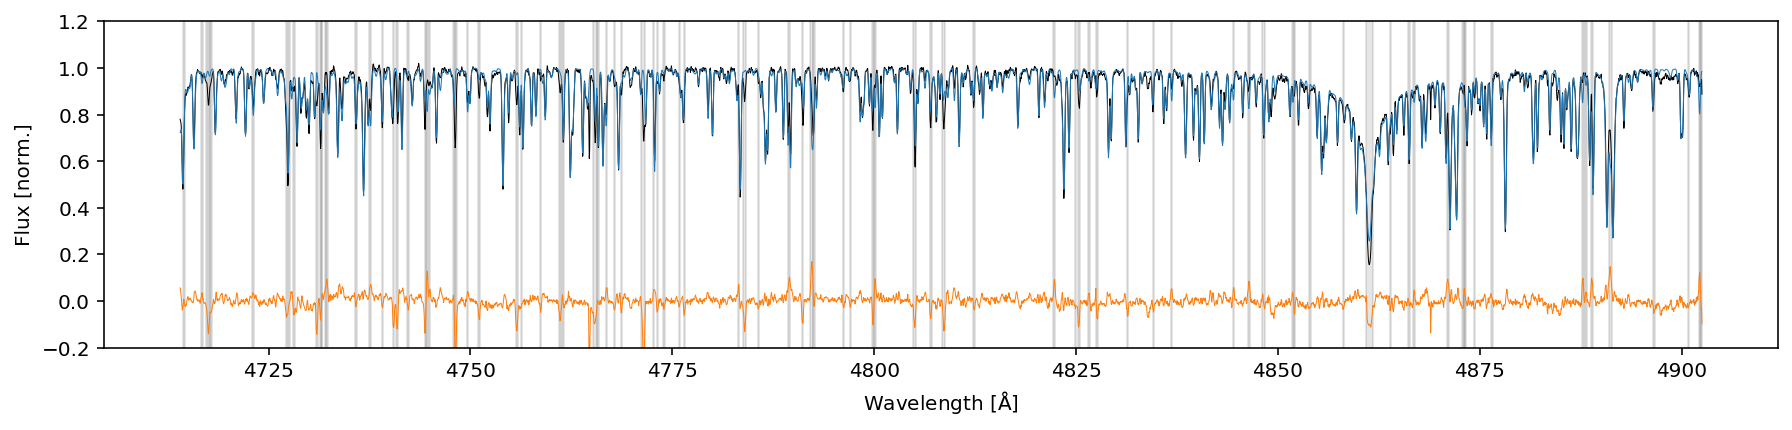

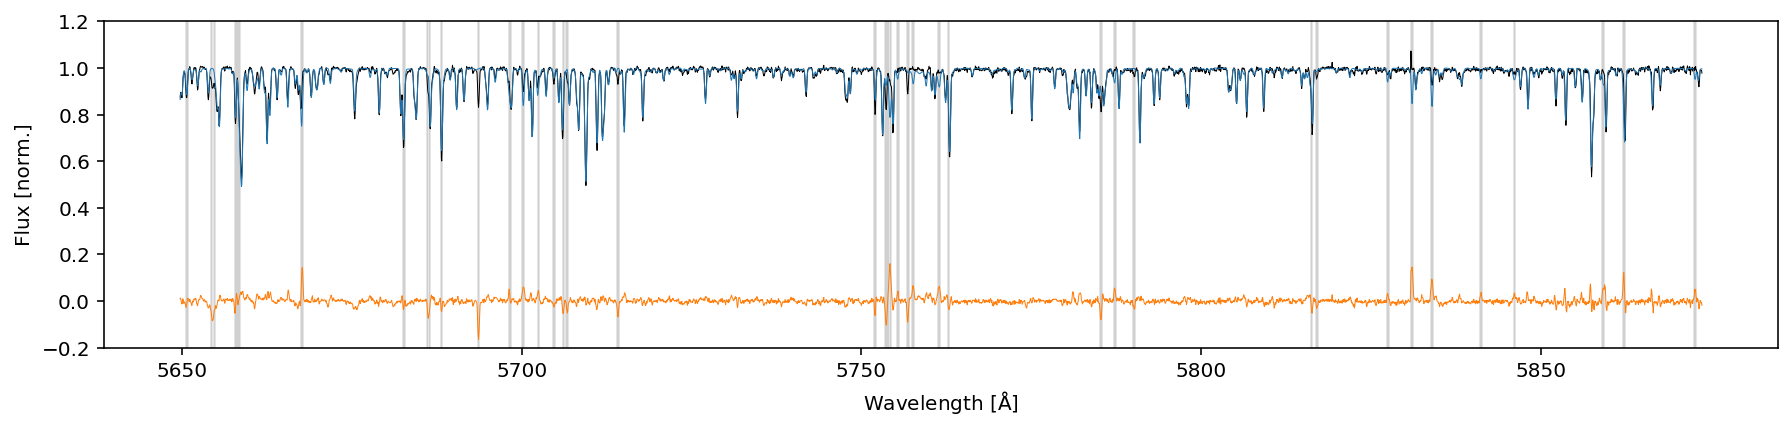

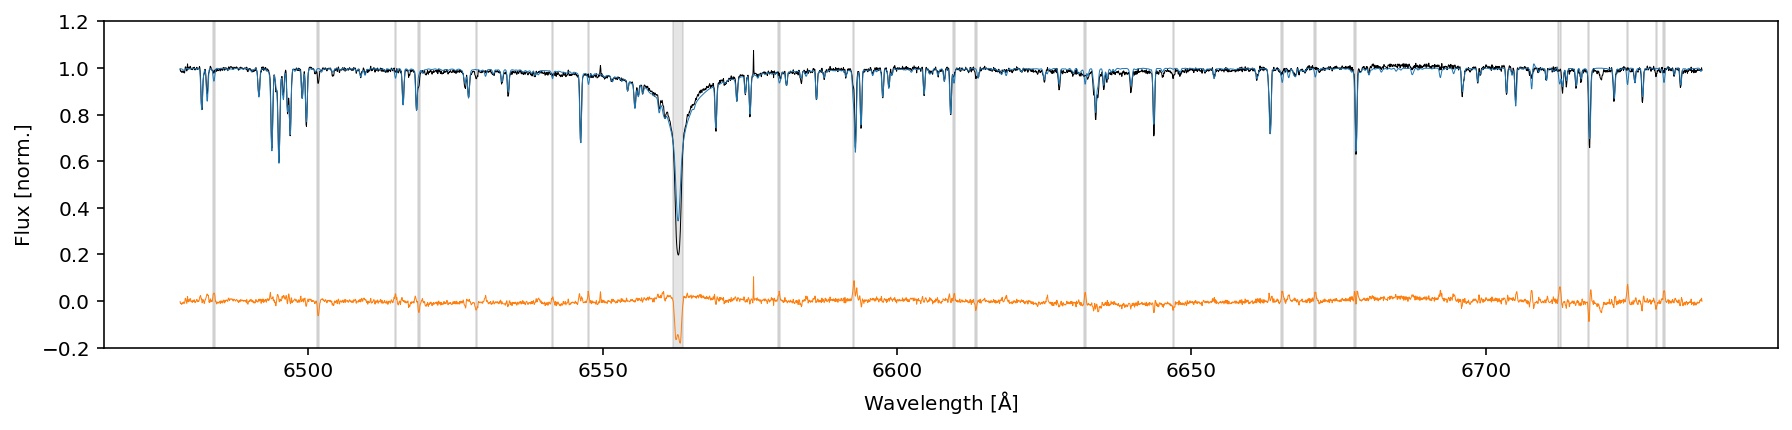

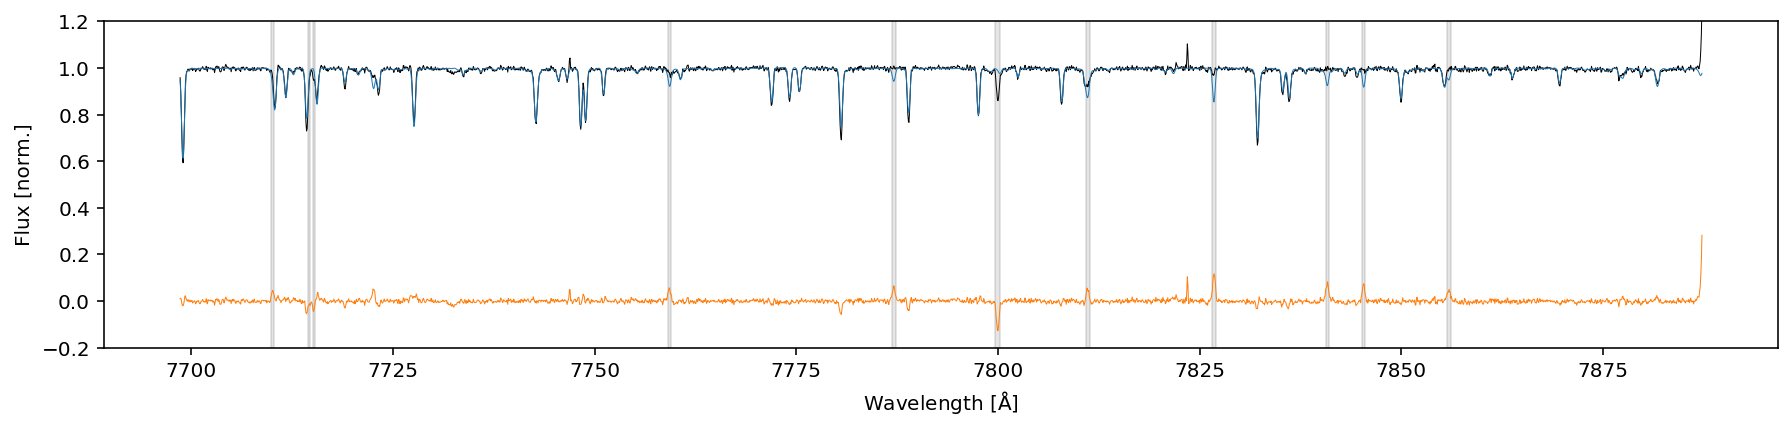

In [55]:
dict_initial = plot_observation_and_model(
    initial_model_parameters, 
    model_labels, spectrum, masks, default_model, default_model_name
)

2.429173707962036


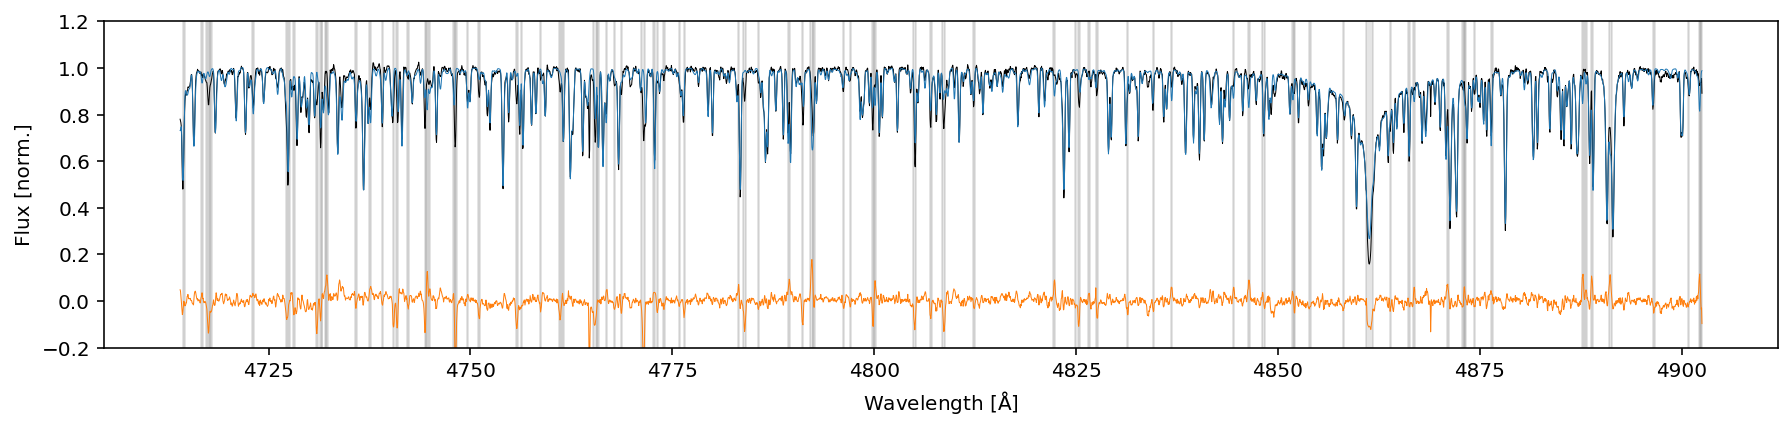

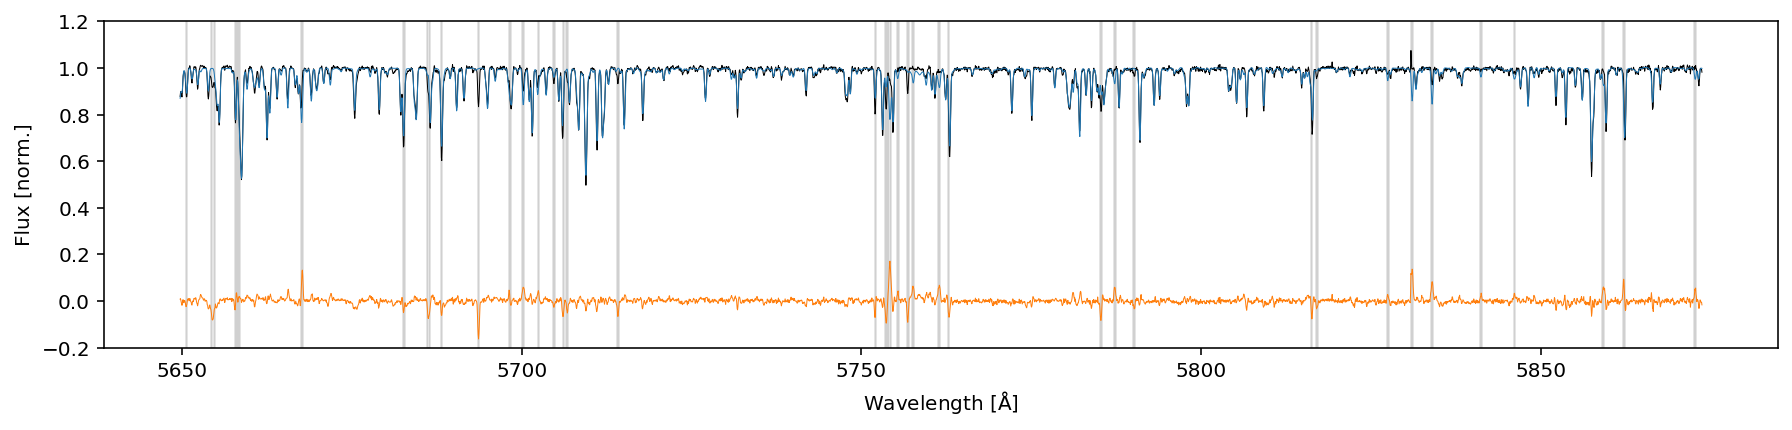

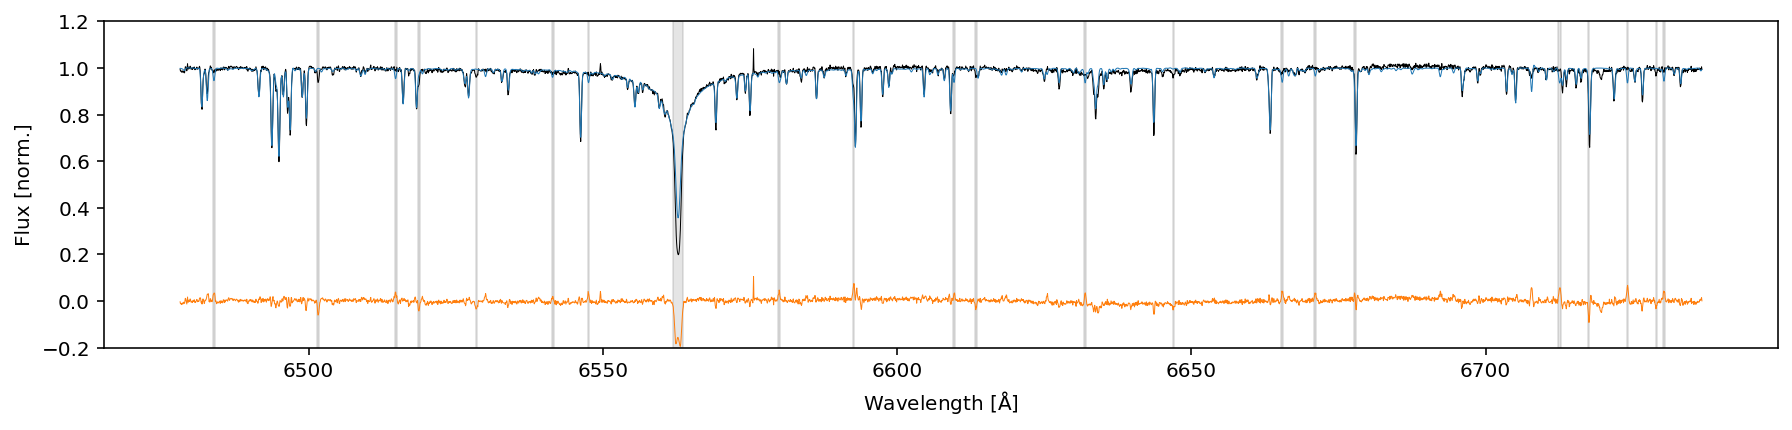

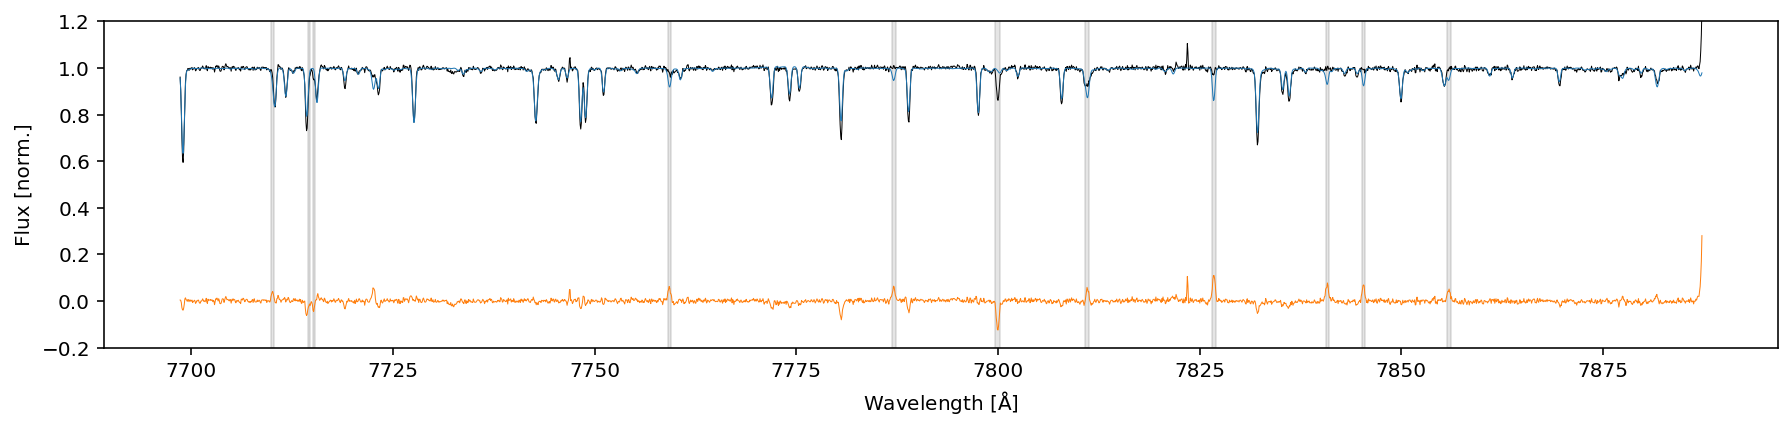

In [56]:
start=time.time()
dict_minise = plot_observation_and_model(
    Maximum_logL.x, 
    model_labels, spectrum, masks, default_model, default_model_name
)
print(time.time()-start)

(6500, 6600)

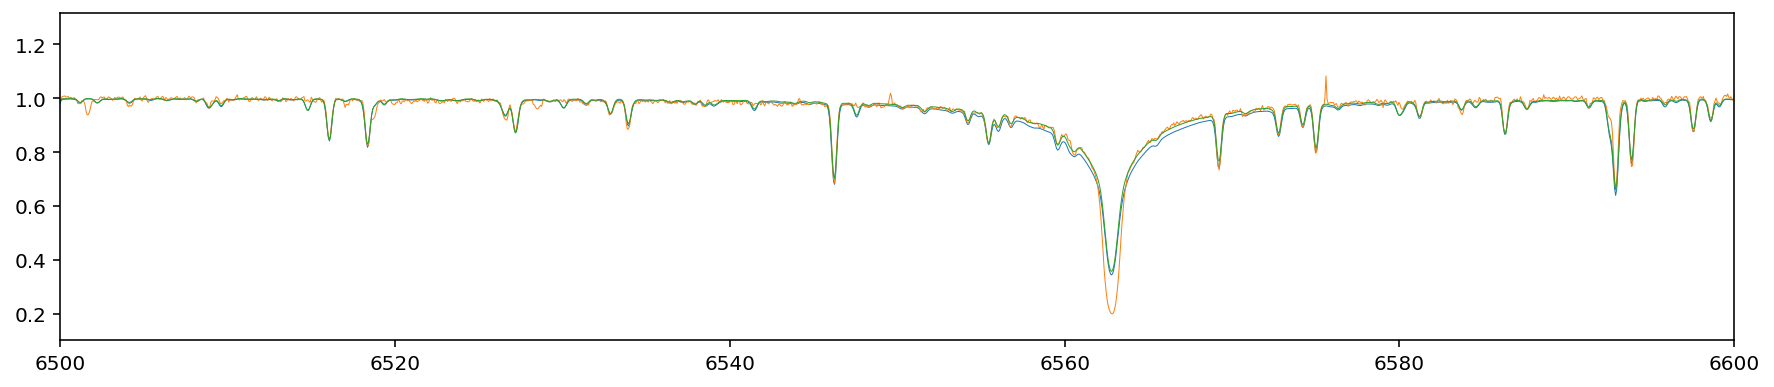

In [57]:
plt.figure(figsize=(15,3))
plt.plot(
    dict_initial['wave'],
    dict_initial['model'],lw=0.5
)
plt.plot(
    dict_minise['wave'],
    dict_minise['data'],lw=0.5
)
plt.plot(
    dict_minise['wave'],
    dict_minise['model'],lw=0.5
)
plt.xlim(6500,6600)

In [58]:
# logg_sampling = np.linspace(
#     #1.5,4.5,25
#     0.0,4.5,25
# )

# # log_p_spa = np.array([
# #     log_probability(
# #     model_parameters = [
# #         spectrum['init_vrad'],
# #         spectrum['init_teff'],
# #         logg,
# #         spectrum['init_fe_h'],
# #         spectrum['init_vmic'],
# #         spectrum['init_vsini'],
# #         ((1./non_spec_info['parallax'] * u.arcsec * u.pc).to(u.pc)).value,
# #         0.0
# #     ],
# #     model_labels = np.array(['vrad','teff','logg','fe_h','vmic','vsini','distance','a_v']),
# #     spectrum=spectrum,
# #     masks=masks,
# #     non_spec_info = non_spec_info,
# #     use_spectroscopy = True,
# #     use_photoastrometry = True,
# #     use_asteroseismology = True
# # ) for logg in logg_sampling
# # ])

# # log_p_sp = np.array([
# #     log_probability(
# #     model_parameters = [
# #         spectrum['init_vrad'],
# #         spectrum['init_teff'],
# #         logg,
# #         spectrum['init_fe_h'],
# #         spectrum['init_vmic'],
# #         spectrum['init_vsini'],
# #         ((1./non_spec_info['parallax'] * u.arcsec * u.pc).to(u.pc)).value,
# #         0.0
# #     ],
# #     model_labels = np.array(['vrad','teff','logg','fe_h','vmic','vsini','distance','a_v']),
# #     spectrum=spectrum,
# #     masks=masks,
# #     non_spec_info = non_spec_info,
# #     use_spectroscopy = True,
# #     use_photoastrometry = True,
# #     use_asteroseismology = False
# # ) for logg in logg_sampling
# # ])

# # log_p_sa = np.array([
# #     log_probability(
# #     model_parameters = [
# #         spectrum['init_vrad'],
# #         spectrum['init_teff'],
# #         logg,
# #         spectrum['init_fe_h'],
# #         spectrum['init_vmic'],
# #         spectrum['init_vsini'],
# #         ((1./non_spec_info['parallax'] * u.arcsec * u.pc).to(u.pc)).value,
# #         0.0
# #     ],
# #     model_labels = np.array(['vrad','teff','logg','fe_h','vmic','vsini','distance','a_v']),
# #     spectrum=spectrum,
# #     masks=masks,
# #     non_spec_info = non_spec_info,
# #     use_spectroscopy = True,
# #     use_photoastrometry = False,
# #     use_asteroseismology = True
# # ) for logg in logg_sampling
# # ])

# # log_p_pa = np.array([
# #     log_probability(
# #     model_parameters = [
# #         spectrum['init_vrad'],
# #         spectrum['init_teff'],
# #         logg,
# #         spectrum['init_fe_h'],
# #         spectrum['init_vmic'],
# #         spectrum['init_vsini'],
# #         ((1./non_spec_info['parallax'] * u.arcsec * u.pc).to(u.pc)).value,
# #         0.0
# #     ],
# #     model_labels = np.array(['vrad','teff','logg','fe_h','vmic','vsini','distance','a_v']),
# #     spectrum=spectrum,
# #     masks=masks,
# #     non_spec_info = non_spec_info,
# #     use_spectroscopy = False,
# #     use_photoastrometry = True,
# #     use_asteroseismology = True
# # ) for logg in logg_sampling
# # ])

# # log_p_s = np.array([
# #     log_probability(
# #     model_parameters = [
# #         spectrum['init_vrad'],
# #         spectrum['init_teff'],
# #         logg,
# #         spectrum['init_fe_h'],
# #         spectrum['init_vmic'],
# #         spectrum['init_vsini'],
# #         ((1./non_spec_info['parallax'] * u.arcsec * u.pc).to(u.pc)).value,
# #         0.0
# #     ],
# #     model_labels = np.array(['vrad','teff','logg','fe_h','vmic','vsini','distance','a_v']),
# #     spectrum=spectrum,
# #     masks=masks,
# #     non_spec_info = non_spec_info,
# #     use_spectroscopy = True,
# #     use_photoastrometry = False,
# #     use_asteroseismology = False
# # ) for logg in logg_sampling
# # ])

# # log_p_p = np.array([
# #     log_probability(
# #     model_parameters = [
# #         spectrum['init_vrad'],
# #         spectrum['init_teff'],
# #         logg,
# #         spectrum['init_fe_h'],
# #         spectrum['init_vmic'],
# #         spectrum['init_vsini'],
# #         ((1./non_spec_info['parallax'] * u.arcsec * u.pc).to(u.pc)).value,
# #         0.0
# #     ],
# #     model_labels = np.array(['vrad','teff','logg','fe_h','vmic','vsini','distance','a_v']),
# #     spectrum=spectrum,
# #     masks=masks,
# #     non_spec_info = non_spec_info,
# #     use_spectroscopy = False,
# #     use_photoastrometry = True,
# #     use_asteroseismology = False
# # ) for logg in logg_sampling
# # ])

# # log_p_a = np.array([
# #     log_probability(
# #     model_parameters = [
# #         spectrum['init_vrad'],
# #         spectrum['init_teff'],
# #         logg,
# #         spectrum['init_fe_h'],
# #         spectrum['init_vmic'],
# #         spectrum['init_vsini'],
# #         ((1./non_spec_info['parallax'] * u.arcsec * u.pc).to(u.pc)).value,
# #         0.0
# #     ],
# #     model_labels = np.array(['vrad','teff','logg','fe_h','vmic','vsini','distance','a_v']),
# #     spectrum=spectrum,
# #     masks=masks,
# #     non_spec_info = non_spec_info,
# #     use_spectroscopy = False,
# #     use_photoastrometry = False,
# #     use_asteroseismology = True
# # ) for logg in logg_sampling
# # ])

In [59]:
# logg_below_value = (logg_sampling < 5)

# f, gs = plt.subplots(2,4,figsize=(12,8),sharex=True)

# # ax = gs[0,0]
# # ax.plot(
# #     logg_sampling,
# #     log_p_spa,
# #     label='$\ln(P)$ S+P+A'
# # )
# # ax.legend()
# # ax.set_ylabel('$\ln(P)$')

# # ax = gs[0,1]
# # ax.plot(
# #     logg_sampling,
# #     log_p_sp,
# #     label='$\ln(P)$ spec+photo'
# # )
# # ax.legend()

# ax = gs[0,2]
# ax.plot(
#     logg_sampling,
#     log_p_sa,
#     label='$\ln(P)$ spec+astero'
# )
# ax.legend()

# # ax = gs[0,3]
# # ax.plot(
# #     logg_sampling[logg_below_value],
# #     log_p_pa[logg_below_value],
# #     label='$\ln(P)$ photo+astero'
# # )
# # ax.legend()
# # ax.set_xlabel('$\ln (g~/~\mathrm{cm\,s^{-2}})$')
# # ax.set_ylabel('$\ln(P)$')

# ax = gs[1,0]
# ax.plot(
#     logg_sampling,
#     log_p_s,
#     label='$\ln(P)$ spec'
# )
# ax.legend()
# ax.set_xlabel('$\ln (g~/~\mathrm{cm\,s^{-2}})$')
# ax.set_ylabel('$\ln(P)$')

# # ax = gs[1,1]
# # ax.plot(
# #     logg_sampling,
# #     log_p_p,
# #     label='$\ln(P)$ photo'
# # )
# # ax.legend()
# # ax.set_xlabel('$\ln (g~/~\mathrm{cm\,s^{-2}})$')

# ax = gs[1,2]
# ax.plot(
#     logg_sampling[logg_below_value],
#     log_p_a[logg_below_value],
#     label='$\ln(P)$ astero'
# )
# ax.set_ylim(2*np.median(log_p_a[logg_below_value]),0)
# ax.legend()
# ax.set_xlabel('$\ln (g~/~\mathrm{cm\,s^{-2}})$')

# plt.tight_layout()

# Optimisation

In [60]:
number_steps = 5
step_burnin = int(number_steps/5)

In [66]:
start = time.time()
log_probability(
    Maximum_logL.x,
    model_labels, spectrum, masks, non_spec_info, True, False, False, default_model, default_model_name, reuse_initial_res_wave_grid=True, debug=False
)
print('full time: ',time.time()-start)
#1.08s with reading in Cannon spectrum & debug
#0.70s with reading in Cannon spectrum, without debug
#0.69s without reading in Cannon spectrum, with debug
#0.33s without reading in Cannon spectrum, without debug


full time:  0.08162403106689453


In [ ]:
# Initialize the walkers
coords = Maximum_logL.x + 1e-4 * np.random.randn(5*len(model_labels), len(model_labels))
nwalkers, ndim = coords.shape

# Set up the backend
# Don't forget to clear it in case the file already exists
file_directory = working_directory+'/analysis_products/diagnostic_plots/'+str(spectrum['sobject_id'])[:6]+'/mcmc/'
Path(file_directory).mkdir(parents=True, exist_ok=True)

backend = emcee.backends.HDFBackend(file_directory+str(spectrum['sobject_id'])+'_sample.h5')
backend.reset(nwalkers, ndim)

# Walk that walk
sampler = emcee.EnsembleSampler(
    nwalkers, ndim, log_probability, args=(model_labels, spectrum, masks, non_spec_info, True, False, False, default_model, default_model_name, True, False),
    backend=backend
)

sampler.run_mcmc(coords, number_steps, progress=True);

  0%|          | 0/5 [00:00<?, ?it/s]

In [ ]:
print('checkout more: https://emcee.readthedocs.io/en/stable/tutorials/monitor/')

In [ ]:
# max_n = 100000

# # We'll track how the average autocorrelation time estimate changes
# index = 0
# autocorr = np.empty(max_n)

# # This will be useful to testing convergence
# old_tau = np.inf

# # Now we'll sample for up to max_n steps
# for sample in sampler.sample(coords, iterations=max_n, progress=True):
#     # Only check convergence every 100 steps
#     if sampler.iteration % 100:
#         continue

#     # Compute the autocorrelation time so far
#     # Using tol=0 means that we'll always get an estimate even
#     # if it isn't trustworthy
#     tau = sampler.get_autocorr_time(tol=0)
#     autocorr[index] = np.mean(tau)
#     index += 1

#     # Check convergence
#     converged = np.all(tau * 100 < sampler.iteration)
#     converged &= np.all(np.abs(old_tau - tau) / tau < 0.01)
#     if converged:
#         break
#     old_tau = tau

In [ ]:
file_directory = working_directory+'/analysis_products/diagnostic_plots/'+str(spectrum['sobject_id'])[:6]+'/mcmc/'
Path(file_directory).mkdir(parents=True, exist_ok=True)

fig, axes = plt.subplots(len(model_labels), figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.axvline(step_burnin)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(model_labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");
plt.savefig(file_directory+'/mcmc_chain_'+str(spectrum['sobject_id'])+'.png',bbox_inches='tight')
plt.show()
plt.close()

In [ ]:
try:
    tau = sampler.get_autocorr_time()
except Exception as exc:
    print(exc)
    pass

In [ ]:
try:
    tau = sampler.get_autocorr_time()
    burnin = int(2 * np.max(tau))
    thin = int(0.5 * np.min(tau))
    samples = sampler.get_chain(discard=burnin, flat=True, thin=thin)
    log_prob_samples = sampler.get_log_prob(discard=burnin, flat=True, thin=thin)
    log_prior_samples = sampler.get_blobs(discard=burnin, flat=True, thin=thin)
    
    print("burn-in: {0}".format(burnin))
    print("thin: {0}".format(thin))
    print("flat chain shape: {0}".format(samples.shape))
    print("flat log prob shape: {0}".format(log_prob_samples.shape))
    print("flat log prior shape: {0}".format(log_prior_samples.shape))

    all_samples = np.concatenate(
        (samples, log_prob_samples[:, None], log_prior_samples[:, None]), axis=1
    )

    labels = list(map(r"$\theta_{{{0}}}$".format, range(1, ndim + 1)))
    labels += ["log prob", "log prior"]

    corner.corner(all_samples, labels=labels);
except:
    pass

In [ ]:
flat_samples = sampler.get_chain(discard=step_burnin, thin=1, flat=True)
print(flat_samples.shape)

In [ ]:
flat_samples

In [ ]:
np.save(file_directory+'samples_'+str(spectrum['sobject_id'])+'.npy',flat_samples)

In [ ]:
file_directory = working_directory+'/analysis_products/diagnostic_plots/'+str(spectrum['sobject_id'])[:6]+'/mcmc/'
Path(file_directory).mkdir(parents=True, exist_ok=True)

fig = corner.corner(
    flat_samples, labels=model_labels, truths=minisation.x
);
plt.savefig(file_directory+'/mcmc_corner_'+str(spectrum['sobject_id'])+'.png',bbox_inches='tight')
plt.show()
plt.close()

In [ ]:
dict_mcmc = plot_observation_and_model(
    np.median(flat_samples,axis=0), 
    model_labels, spectrum, masks, default_model, default_model_name
)

In [ ]:
output = Table()

file_directory = working_directory+'/analysis_products/fitting_output/'+str(spectrum['sobject_id'])[:6]+'/'
Path(file_directory).mkdir(parents=True, exist_ok=True)

for label in ['sobject_id','tmass_id','gaia_edr3_source_id']:
    col = Table.Column(
        name=label,
        data = [spectrum[label]],
        description=description[label],
        unit=units[label])
    output.add_column(col)

for label_index, label in enumerate(model_labels):
    percentiles = np.percentile(flat_samples[:, label_index], [16, 50, 84])
    col = Table.Column(
        name=label,
        data = [np.float32(percentiles[1])],
        description=description[label],
        unit=units[label])
    output.add_column(col)
    col = Table.Column(
        name=label+'_16',
        data = [np.float32(percentiles[1]-percentiles[0])],
        description='Difference to 16th percentile of '+description[label],
        unit=units[label])
    output.add_column(col)
    col = Table.Column(
        name=label+'_84',
        data = [np.float32(percentiles[2]-percentiles[1])],
        description='Difference to 84th percentile of '+description[label],
        unit=units[label])
    output.add_column(col)

output.write(file_directory+str(spectrum['sobject_id'])+'_logL_MCMC_results.fits',overwrite=True)

In [ ]:
output

In [ ]:
log_probability(
    np.median(flat_samples,axis=0),
    model_labels, spectrum, masks, non_spec_info, True, True, True, True
)

In [ ]:
np.median(flat_samples,axis=0)

In [ ]:
# def fit_leastsq(initial_model_parameters, model_labels, spectrum, masks, debug=False):

#     def residuals_for_leastsq(parameters):

#         print(parameters)
#         (wave,data,sigma2,model,s2) = match_observation_and_model(model_parameters=parameters, model_labels=model_labels, spectrum=spectrum, masks=masks, debug=False)
#         masked = np.any(np.array([((wave >= mask_beginning) & (wave <= mask_end)) for (mask_beginning, mask_end) in masks]),axis=0)
        
#         adjusted_sigma = sigma2 + s2
#         adjusted_sigma[masked] = 100000.
        
#         return (model - data)/np.sqrt(adjusted_sigma)
    
#     kwds = {
#             "func": residuals_for_leastsq,
#             "Dfun": None,
#             "col_deriv": True,

#             # These get passed through to leastsq:
#             "ftol": 7./3 - 4./3 - 1, # Machine precision.
#             "xtol": 7./3 - 4./3 - 1, # Machine precision.
#             "gtol": 0.0,
#             "maxfev": 100000, # MAGIC
#             "epsfcn": None,
#             "factor": 1.0,
#         }

#     op_labels, cov, meta, mesg, ier = op.leastsq(
#         x0 = initial_model_parameters,
#         full_output=True,**kwds
#     )
    
#     return(op_labels, cov, meta, mesg, ier)

# start_time = time.time()
# initial_model_parameters = [
#     spectrum['init_vrad'],
#     spectrum['init_teff'],
#     spectrum['init_logg'],
#     spectrum['init_fe_h'],
#     spectrum['init_vmic'],
#     0.0,
#     0.0
# ]
# model_labels=np.array(['vrad','teff','logg','fe_h','vmic','li_fe','k_fe'])
# op_labels, cov, meta, mesg, ier = fit_leastsq(initial_model_parameters, model_labels, spectrum, masks, debug=False)
# print(time.time() - start_time)
# # 31s for 47 calls for 4 parameters
# # 259s for 6 parameters
# # 118s for 11 parameters

In [ ]:
op_labels

In [ ]:
outcome = Table()
for each_index, label in enumerate(model_labels):
    outcome[label] = [op_labels[each_index]]
outcome